# Общее описание `transaction_fraud_data.parquet`

Этот анонимизированный набор данных реальных финансовые транзакции, который предназначен для разработки и тестирования моделей выявления мошеннических операций.

Он охватывает различные сценарии — от розничной торговли и ресторанов до путешествий и здравоохранения — и включает как легитимные, так и мошеннические операции. В нём представлены важные признаки, влияющие на распознавание мошенничества: сумма, тип устройства, география, валюта, тип карты и метка `is_fraud`.


## Ключевые особенности

- **Разнообразие категорий**: Розница (онлайн и офлайн), рестораны (фастфуд и премиум), развлечения, здравоохранение, образование, топливо, путешествия и др.
- **География и валюта**: Транзакции охватывают разные страны, города и валюты, что позволяет моделировать глобальные риски.
- **Профили клиентов**: Для каждой транзакции предусмотрены данные о клиенте — возраст аккаунта, используемые устройства, типичные траты, уровень защиты от мошенничества.
- **Данные, готовые для ML**: Признаки включают скорость транзакций, риск вендора, присутствие карты, отпечатки устройств и другие факторы, помогающие обнаруживать подозрительные паттерны.


## Возможные применения

- Построение моделей выявления мошенничества.
- Анализ транзакционного поведения клиентов.
- Разработка и тестирование алгоритмов обнаружения аномалий.
- Изучение методов feature engineering, оценки моделей и оптимизации производительности в сфере финтеха и e-commerce.

# Содержание файла `transaction_fraud_data.parquet`

| Поле | Описание | Тип |
|------|----------|-----|
| `transaction_id` | Уникальный идентификатор транзакции | String |
| `customer_id` | Уникальный идентификатор клиента | String |
| `card_number` | Маскированный номер карты | Int64 |
| `timestamp` | Дата и время транзакции | Datetime(time_unit='us') |
| `vendor_category` | Общая категория вендора (например, Розница, Путешествия) | String |
| `vendor_type` | Тип вендора внутри категории (например, "онлайн") | String |
| `vendor` | Название вендора | String |
| `amount` | Сумма транзакции | Float64 |
| `currency` | Валюта (например, USD, EUR, JPY) | String |
| `country` | Страна, где проведена транзакция | String |
| `city` | Город, где проведена транзакция | String |
| `city_size` | Размер города (например, средний, крупный) | String |
| `card_type` | Тип карты (например, Basic Credit, Gold Credit) | String |
| `is_card_present` | Присутствовала ли карта физически при оплате (POS) | Boolean |
| `device` | Устройство, с которого проведена транзакция (например, Chrome, iOS App) | String |
| `channel` | Канал проведения транзакции (веб, мобильный, POS) | String |
| `device_fingerprint` | Уникальный отпечаток устройства | String |
| `ip_address` | IP-адрес транзакции | String |
| `is_outside_home_country` | Признак того, что операция проведена вне страны клиента | Boolean |
| `is_high_risk_vendor` | Является ли категория вендора рискованной (например, Путешествия, Развлечения) | Boolean |
| `is_weekend` | Произошла ли операция в выходной день | Boolean |
| `last_hour_activity` | Показатели активности за последний час в виде вложенной структуры | Struct({'num_transactions': Int64, 'total_amount': Float64, 'unique_merchants': Int64, 'unique_countries': Int64, 'max_single_amount': Float64}) |
| `is_fraud` | Является ли транзакция мошеннической (`True` / `False`) | Boolean |

Составное поле `last_hour_activity`:

| Ключ | Описание | Тип |
|------|----------|-----|
| `num_transactions` | Количество транзакций | Int64 |
| `total_amount` | Общая сумма транзакций | Float64 |
| `unique_merchants` | Число уникальных продавцов | Int64 |
| `unique_countries` | Число уникальных стран | Int64 |
| `max_single_amount` | Максимальная сумма одной транзакции | Float64 |

# Содержание файла `historical_currency_exchange.parquet`

Вспомогательные данные для перевода операций в нужную валюту.

Обменный курс с `2024-09-30` по `2024-10-30` относительно `USD`.

| Поле | Описание | Тип |
|------|----------|-----|
| `date` | Дата обменного курса | Date |
| `AUD` | Австралийский доллар | Float64 |
| `BRL` | Бразильский реал | Float64 |
| `CAD` | Канадский доллар | Float64 |
| `EUR` | Евро | Float64 |
| `GBP` | Британский фунт стерлингов | Float64 |
| `JPY` | Японская иена | Float64 |
| `MXN` | Мексиканское песо | Float64 |
| `NGN` | Нигерийская найра | Float64 |
| `RUB` | Российский Рубль | Float64 |
| `SGD` | Сингапурский доллар | Float64 |
| `USD` | Доллар США | Int64 |

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from dataclasses import dataclass
import math

# Config Class

In [2]:
@dataclass
class Config:
    historical_currency_exchange_path = 'https://assets.contest.yandex.net/testsys/statement-file?hash=eyJhbGciOiJkaXIiLCJlbmMiOiJBMjU2R0NNIn0..cT_33Wdcfi4sRaiB.doFVKDsSgppwoPVmlJXM6KRP1tDuTQ3SXe0Ue2HvrswtoHAriPL_CeBH1Gnz6reyxlOSVUyRjtRry2MJg65jp48X7fZh1sicC_Mvs2LC3NHx8O1dlMePhpqUAysxxgYxDPZl.G2QKL5I-cDTjzYWaTvMm5Q'
    transaction_fraud_data_path = 'https://assets.contest.yandex.net/testsys/statement-file?hash=eyJhbGciOiJkaXIiLCJlbmMiOiJBMjU2R0NNIn0..gtHw-UhTnAMAC9OK.-O2zZRAE2zLf7Nq9oLSXu9qWScZLnCpVwz0OpeGe7P_o9AKtwGQzHdGV74-dfEyM89QpwMIkYfGCxQlxYCOoGeR8KCl8RjlzC0BFbykT6RlXLf0JEGBzGkr8JAaw.39OMlK9BOYws-HcM8bBJdw'


config = Config()

# Загрузка данных

In [3]:
transactions_df = (
    pd.read_parquet(
        config.transaction_fraud_data_path,
        columns=[
            'transaction_id',
            'customer_id',
            'vendor_category',
            'timestamp',
            'vendor_type',
            'amount',
            'vendor',
            'country',
            'city',
            'is_high_risk_vendor',
            'currency',
            'last_hour_activity',
            'is_fraud'
            ]
    )
)

transactions_df['unique_merchants_last_hour'] = (
    transactions_df['last_hour_activity'].str['unique_merchants']
    .fillna(0)
)

transactions_df.drop(columns=['last_hour_activity'], inplace=True)

## NaN Values

In [4]:
transactions_df.isna().sum()

,0
transaction_id,0
customer_id,0
vendor_category,0
timestamp,0
vendor_type,0
amount,0
vendor,0
country,0
city,0
is_high_risk_vendor,0


## Дубликаты

 ### Дубликаты по `transaction_id` и `customer_id`:

In [5]:
transactions_df[transactions_df.duplicated(subset=['customer_id', 'transaction_id'], keep=False)].sort_values(by=['customer_id', 'transaction_id'], ascending=False)

,transaction_id,customer_id,vendor_category,timestamp,vendor_type,amount,vendor,country,city,is_high_risk_vendor,currency,is_fraud,unique_merchants_last_hour
2743913,TX_1d881541,CUST_34882,Travel,2024-10-11 09:56:38.412378,booking,11660.69,Airbnb,Brazil,Unknown City,True,BRL,False,92
5544230,TX_1d881541,CUST_34882,Restaurant,2024-10-22 23:04:44.494108,casual,578.60,Chili's,Brazil,Unknown City,False,BRL,False,92


### Дубликаты по `transaction_id`:

In [6]:
len(transactions_df) - transactions_df.transaction_id.nunique()

6460

## Приведение данных к одной валюте

In [7]:
transactions_df.drop_duplicates(subset=['transaction_id', 'customer_id'],
                                inplace=True)

transactions_df['date'] = transactions_df['timestamp'].dt.normalize()

exchange_rates_long = (
    pd.melt(
        pd.read_parquet(config.historical_currency_exchange_path),
        id_vars=['date'],
        var_name='currency',
        value_name='rate_to_usd'
    )
)

exchange_rates_long['date'] = pd.to_datetime(exchange_rates_long['date'])

transactions_df = pd.merge(
    transactions_df,
    exchange_rates_long,
    on=['date', 'currency'],
    how='left'
).copy()

transactions_df['amount_usd'] = transactions_df.apply(
    lambda row: row['amount'] / row['rate_to_usd']
    if row['rate_to_usd'] > 0 else 0,
    axis=1
)

transactions_df.loc[transactions_df['currency'] == 'USD', 'amount_usd'] = transactions_df['amount']

transactions_df = transactions_df.drop(columns=['amount',
                                                'currency',
                                                'rate_to_usd',
                                                # 'timestamp'
                                                ])

transactions_df

,transaction_id,customer_id,vendor_category,timestamp,vendor_type,vendor,country,city,is_high_risk_vendor,is_fraud,unique_merchants_last_hour,date,amount_usd
0,TX_a0ad2a2a,CUST_72886,Restaurant,2024-09-30 00:00:01.034820,fast_food,Taco Bell,UK,Unknown City,False,False,105,2024-09-30,394.658011
1,TX_3599c101,CUST_70474,Entertainment,2024-09-30 00:00:01.764464,gaming,Steam,Brazil,Unknown City,True,True,100,2024-09-30,619.905757
2,TX_a9461c6d,CUST_10715,Grocery,2024-09-30 00:00:02.273762,physical,Whole Foods,Japan,Unknown City,False,False,97,2024-09-30,719.506409
3,TX_7be21fc4,CUST_16193,Gas,2024-09-30 00:00:02.297466,major,Exxon,Australia,Unknown City,False,False,105,2024-09-30,436.808287
4,TX_150f490b,CUST_87572,Healthcare,2024-09-30 00:00:02.544063,medical,Medical Center,Nigeria,Unknown City,False,True,88,2024-09-30,434.430069
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483760,TX_58a762fa,CUST_11344,Retail,2024-10-30 23:59:58.926575,online,AliExpress,Singapore,Unknown City,False,False,1,2024-10-30,670.362079
7483761,TX_dabcf671,CUST_38961,Grocery,2024-10-30 23:59:58.950801,physical,Kroger,France,Unknown City,False,False,0,2024-10-30,385.402905
7483762,TX_ab567eb4,CUST_75576,Grocery,2024-10-30 23:59:58.972155,physical,Kroger,Singapore,Unknown City,False,False,0,2024-10-30,296.122166
7483763,TX_5ae61846,CUST_82508,Retail,2024-10-30 23:59:58.996608,online,eBay,USA,Chicago,False,False,2,2024-10-30,601.710000


# Анализ по категориям и странам

In [8]:
transactions_df.country.unique()

array(['UK', 'Brazil', 'Japan', 'Australia', 'Nigeria', 'Germany',
       'Mexico', 'Russia', 'France', 'Canada', 'Singapore', 'USA'],
      dtype=object)

In [9]:
avg_amount_by_status = (
    transactions_df.groupby(['country',
                             'vendor_category',
                             'is_fraud'])['amount_usd']
    .mean()
    .unstack(level='is_fraud')
    .reset_index()
)
avg_amount_by_status.columns = ['country', 'vendor_category', 'avg_amount_non_fraud', 'avg_amount_fraud']

avg_amount_total = (
    transactions_df
    .groupby(['country', 'vendor_category'])['amount_usd']
    .mean()
    .reset_index()
    .rename(columns={
        'amount_usd': 'avg_amount_total'
        })
)

average_amount_by_country = pd.merge(avg_amount_total,
                                  avg_amount_by_status,
                                  on=['country', 'vendor_category'],
                                  how='left')
average_amount_by_country.fillna(0, inplace=True)

average_amount_by_country

,country,vendor_category,avg_amount_total,avg_amount_non_fraud,avg_amount_fraud
0,Australia,Education,505.689416,469.957844,935.532077
1,Australia,Entertainment,368.029483,359.615114,471.001048
2,Australia,Gas,507.894285,474.249134,927.929192
3,Australia,Grocery,426.446298,406.648371,666.902411
4,Australia,Healthcare,509.832355,473.663556,947.019944
...,...,...,...,...,...
91,USA,Grocery,447.776071,424.779642,729.704732
92,USA,Healthcare,540.113380,499.478294,1044.271444
93,USA,Restaurant,361.956882,355.298233,444.166689
94,USA,Retail,680.219673,610.934418,1552.442037


In [10]:
top_5_countries = (
    transactions_df[transactions_df['is_fraud']]['country']
    .value_counts()
    .head(5)
)
print("Топ-5 стран с наибольшим количеством мошеннических транзакций:")
print(top_5_countries)

Топ-5 стран с наибольшим количеством мошеннических транзакций:
country
Russia       299425
Mexico       298841
Brazil       298629
Nigeria      298600
Australia     37652
Name: count, dtype: int64


In [11]:
pivot_for_sorting = average_amount_by_country.pivot(index='country',
                                                 columns='vendor_category',
                                                 values='avg_amount_total')
pivot_for_sorting

vendor_category,Education,Entertainment,Gas,Grocery,Healthcare,Restaurant,Retail,Travel
country,,,,,,,,
Australia,505.689416,368.029483,507.894285,426.446298,509.832355,348.624125,636.408697,956.906239
Brazil,635.401711,398.356550,632.715990,494.205275,637.197202,353.906545,859.326853,1393.963258
Canada,481.679668,345.086452,484.748491,399.805516,484.208672,323.545617,612.332977,925.218603
France,503.335083,365.056622,504.455445,422.582398,504.474067,344.284714,633.371417,960.750471
Germany,522.481284,383.570345,521.604908,438.538116,523.819274,359.439320,653.617417,983.021121
Japan,417.237125,306.242859,418.206662,352.251175,418.447078,287.764200,518.813410,782.390062
Mexico,727.069307,445.269151,721.711486,559.732255,726.014761,402.151138,983.640541,1612.769354
Nigeria,176.598406,111.329550,177.094098,137.312316,176.536369,100.170563,238.653946,386.525044
Russia,555.427136,343.389344,555.546416,431.275444,555.926595,308.036594,754.179476,1220.076431


In [12]:
def plot_country_data(country_name, data):
    """
    Строит график среднего чека по категории вендора для одной страны.

    Args:
        country_name (str): Название страны, для которого строится график.
        data (pd.DataFrame): DataFrame в "длинном" формате (plot_data_long).
    """
    country_data = data[data['country'] == country_name].copy()

    if country_data.empty:
        print(f"Страна '{country_name}' не найден в данных.")
        return

    fig, ax = plt.subplots(figsize=(12, 8))

    vendor_types = country_data['vendor_category'].unique()
    n_vendors = len(vendor_types)
    statuses = ['Все', 'Легитимные', 'Мошеннические']
    colors = {'Все': '#3498db', 'Легитимные': '#2ecc71', 'Мошеннические': '#e74c3c'}
    bar_width = 0.25
    x_positions = np.arange(n_vendors)

    for k, status in enumerate(statuses):
        offset = (k - 1) * bar_width
        values = []
        for vendor in vendor_types:
            value_row = country_data[(country_data['vendor_category'] == vendor) & (country_data['status'] == status)]
            values.append(value_row['avg_amount'].iloc[0] if not value_row.empty else 0)

        bars = ax.bar(x_positions + offset, values, bar_width, label=status, color=colors[status])
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'${height:.0f}',
                        ha='center', va='bottom', fontsize=9, rotation=90)

    ax.set_title(f'Средний чек по категории вендора в стране: {country_name}', fontsize=16)
    ax.set_ylabel('Средний чек (USD)', fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(vendor_types, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(bottom=0)
    ax.legend(title='Статус транзакции')

    plt.tight_layout()
    plt.show()


plot_data_long = pd.melt(average_amount_by_country,
                         id_vars=['country', 'vendor_category'],
                         value_vars=['avg_amount_total',
                                     'avg_amount_fraud',
                                     'avg_amount_non_fraud'],
                         var_name='status',
                         value_name='avg_amount')
plot_data_long['status'] = plot_data_long['status'].map({'avg_amount_total': 'Все',
                                                         'avg_amount_fraud': 'Мошеннические',
                                                         'avg_amount_non_fraud': 'Легитимные'})
plot_data_long

,country,vendor_category,status,avg_amount
0,Australia,Education,Все,505.689416
1,Australia,Entertainment,Все,368.029483
2,Australia,Gas,Все,507.894285
3,Australia,Grocery,Все,426.446298
4,Australia,Healthcare,Все,509.832355
...,...,...,...,...
283,USA,Grocery,Легитимные,424.779642
284,USA,Healthcare,Легитимные,499.478294
285,USA,Restaurant,Легитимные,355.298233
286,USA,Retail,Легитимные,610.934418


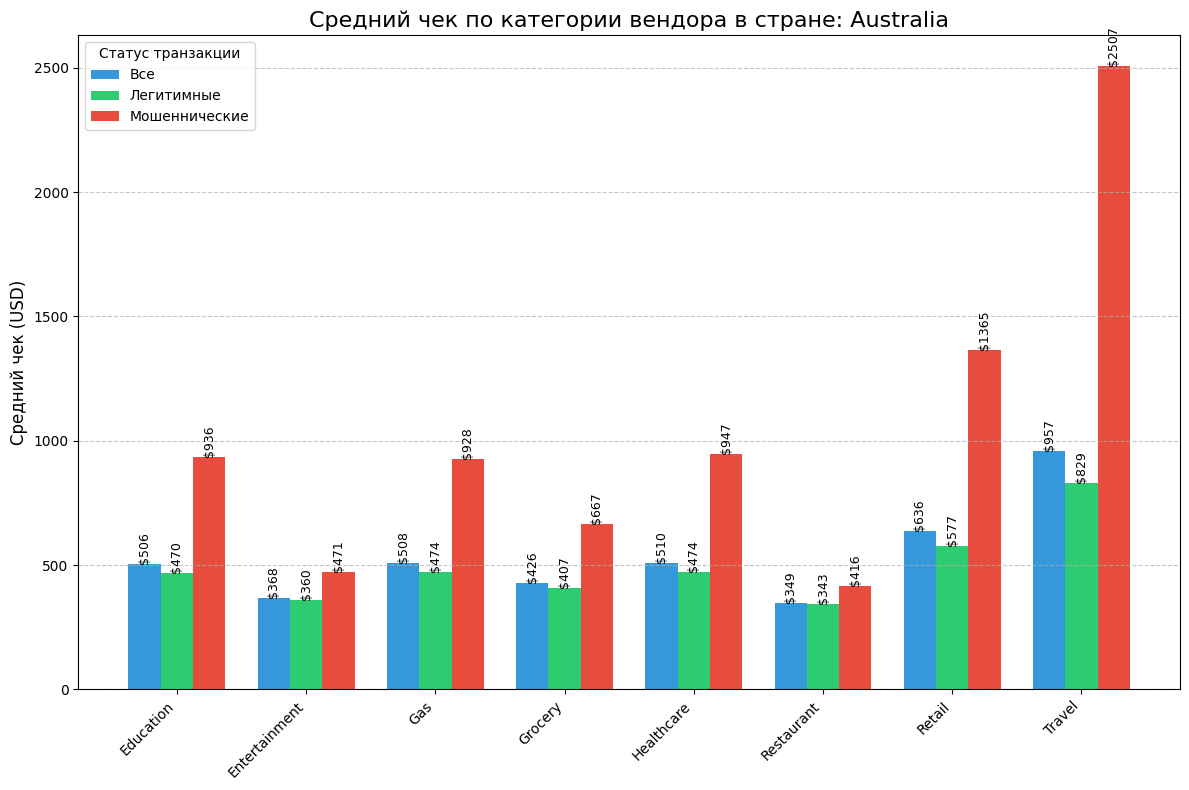

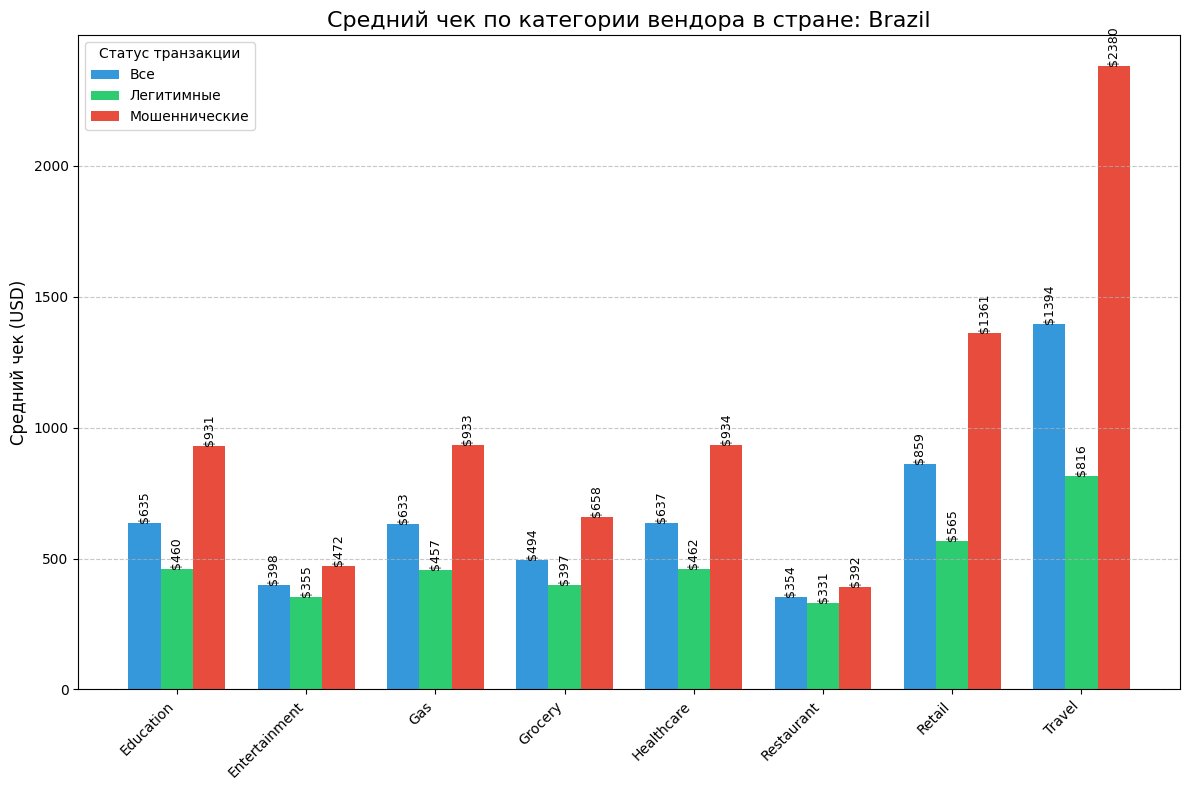

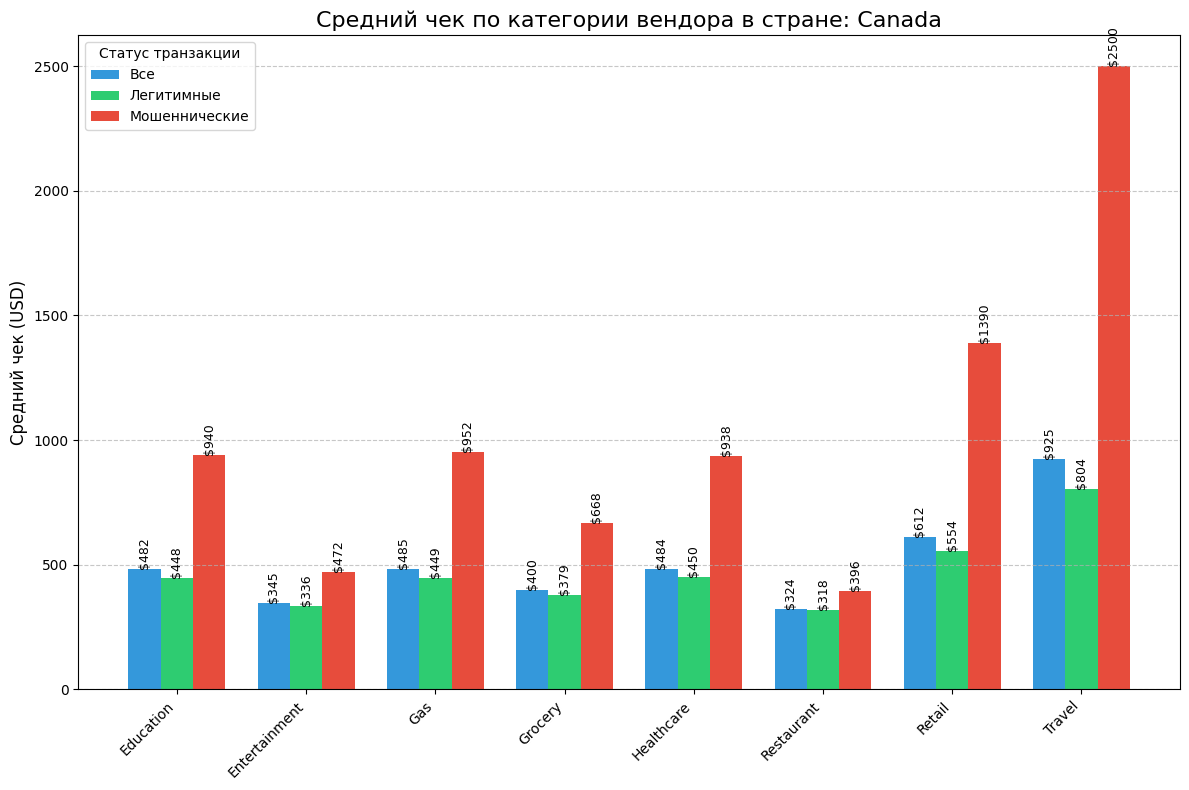

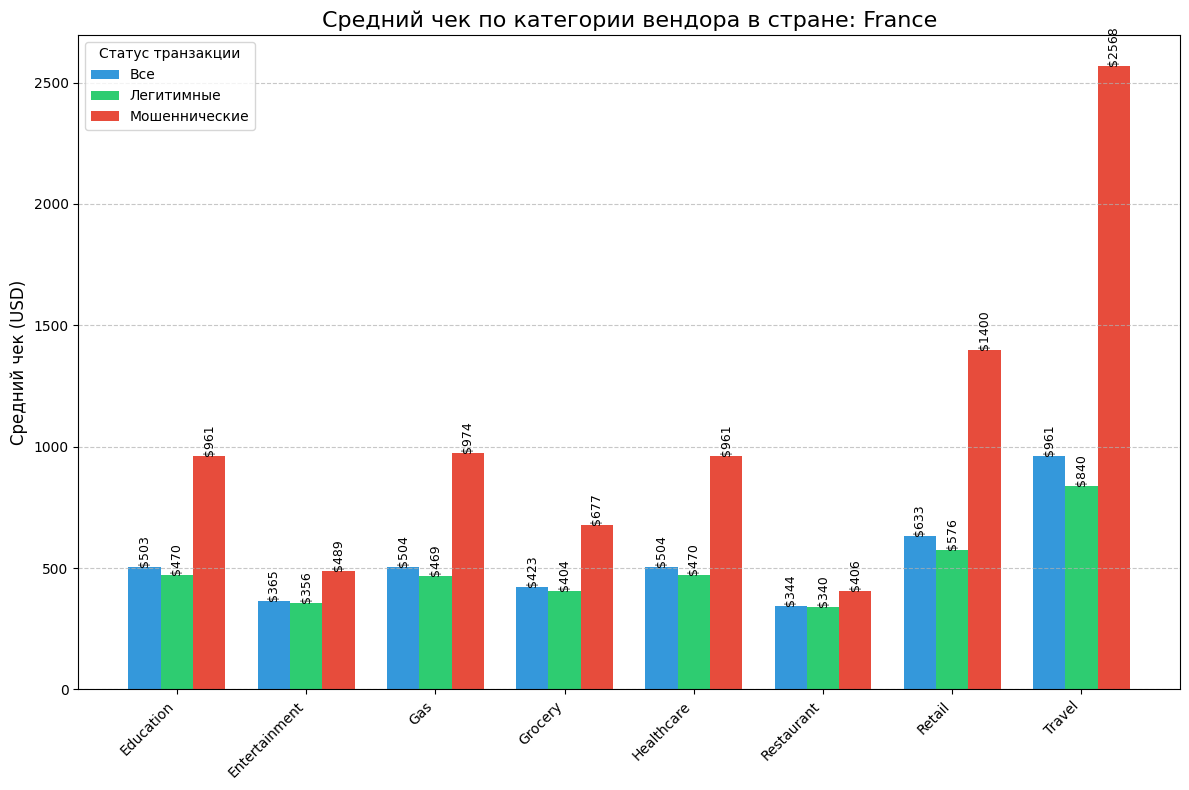

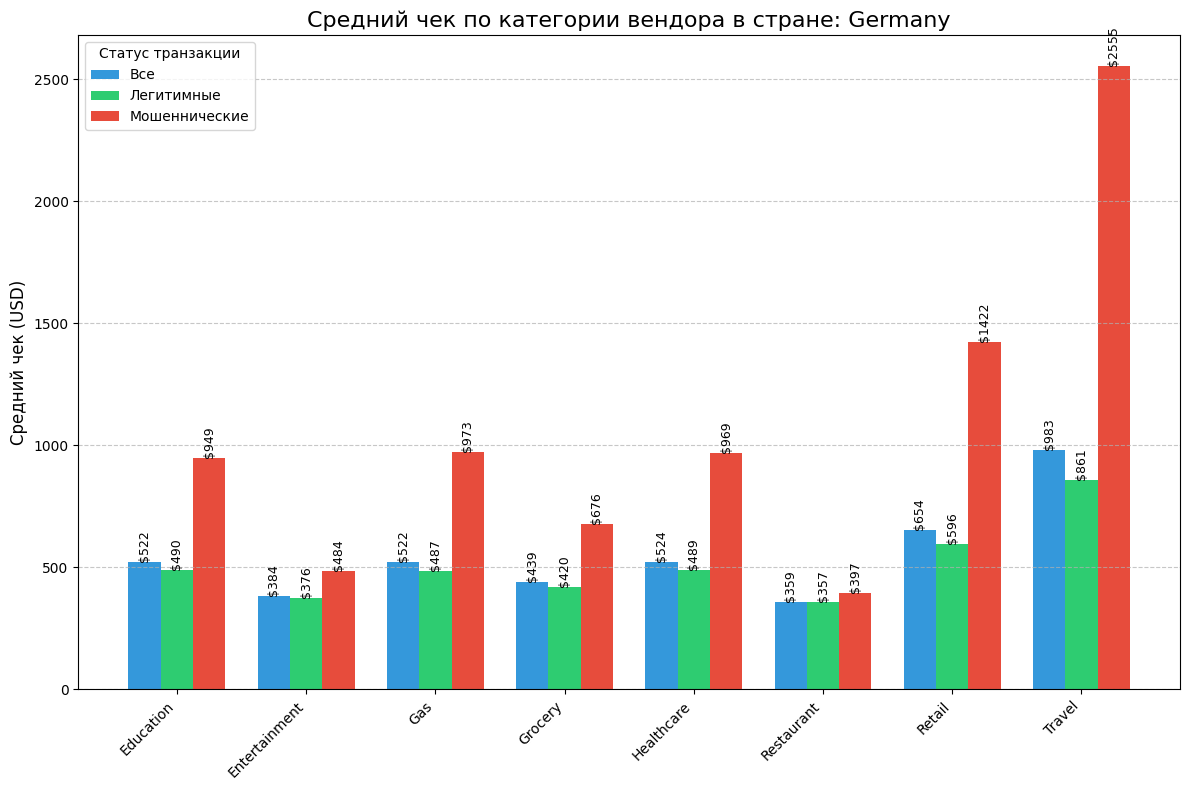

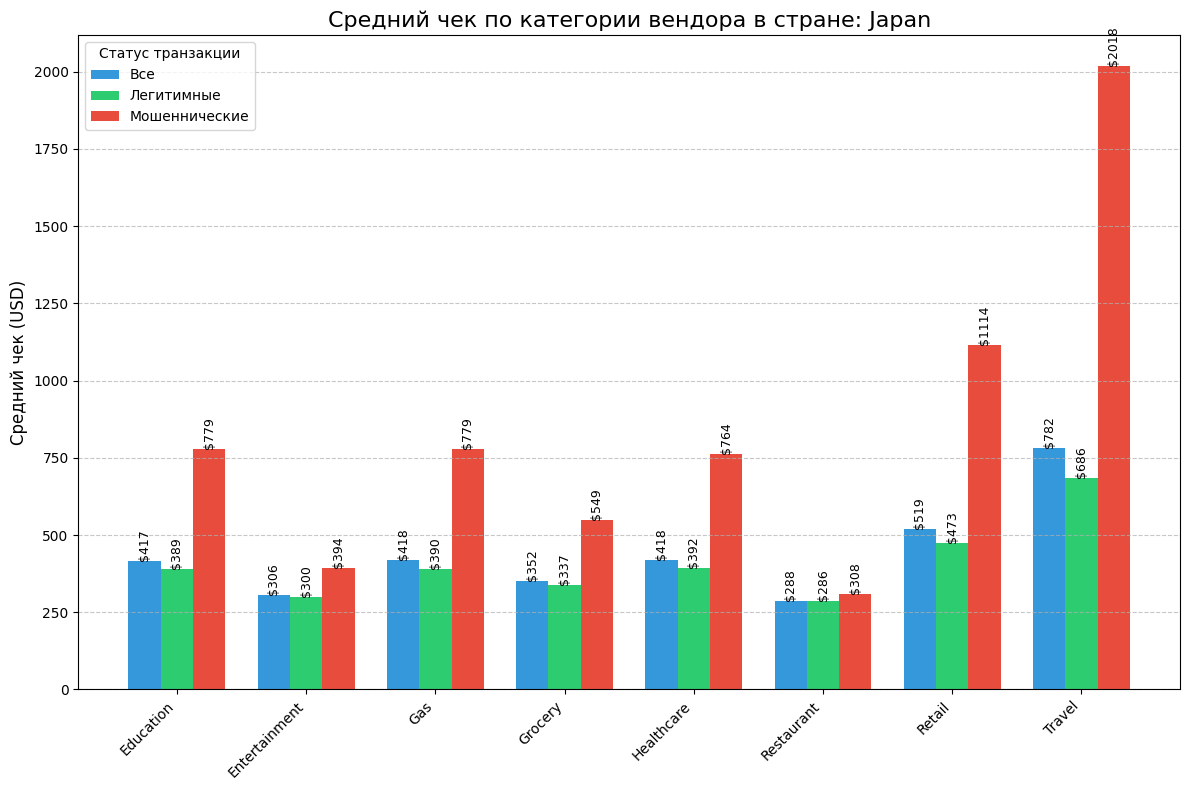

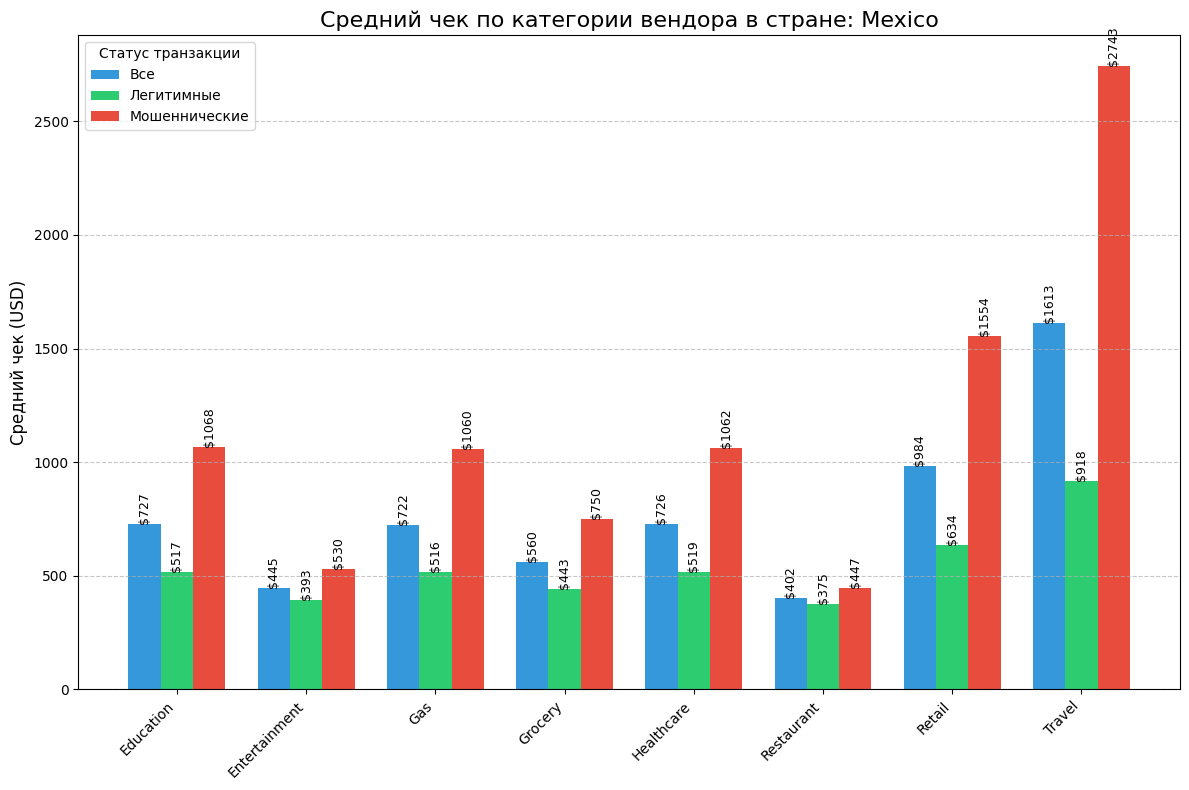

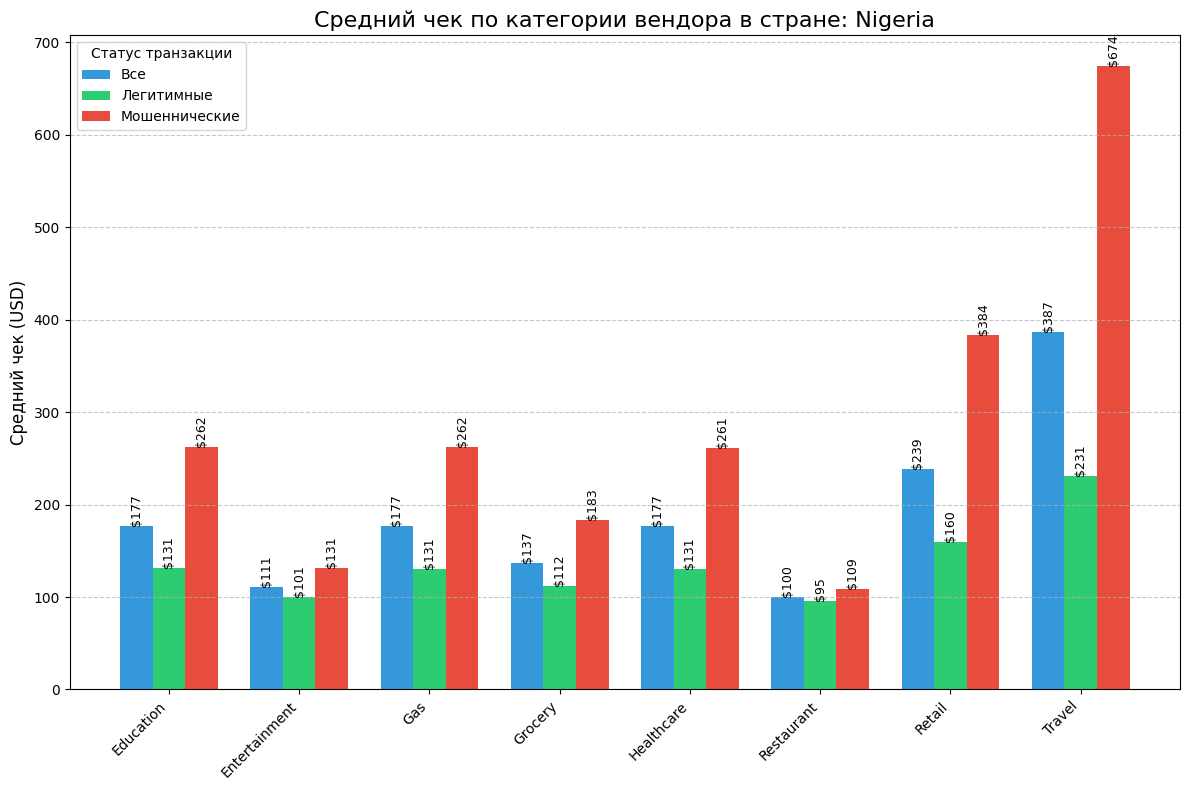

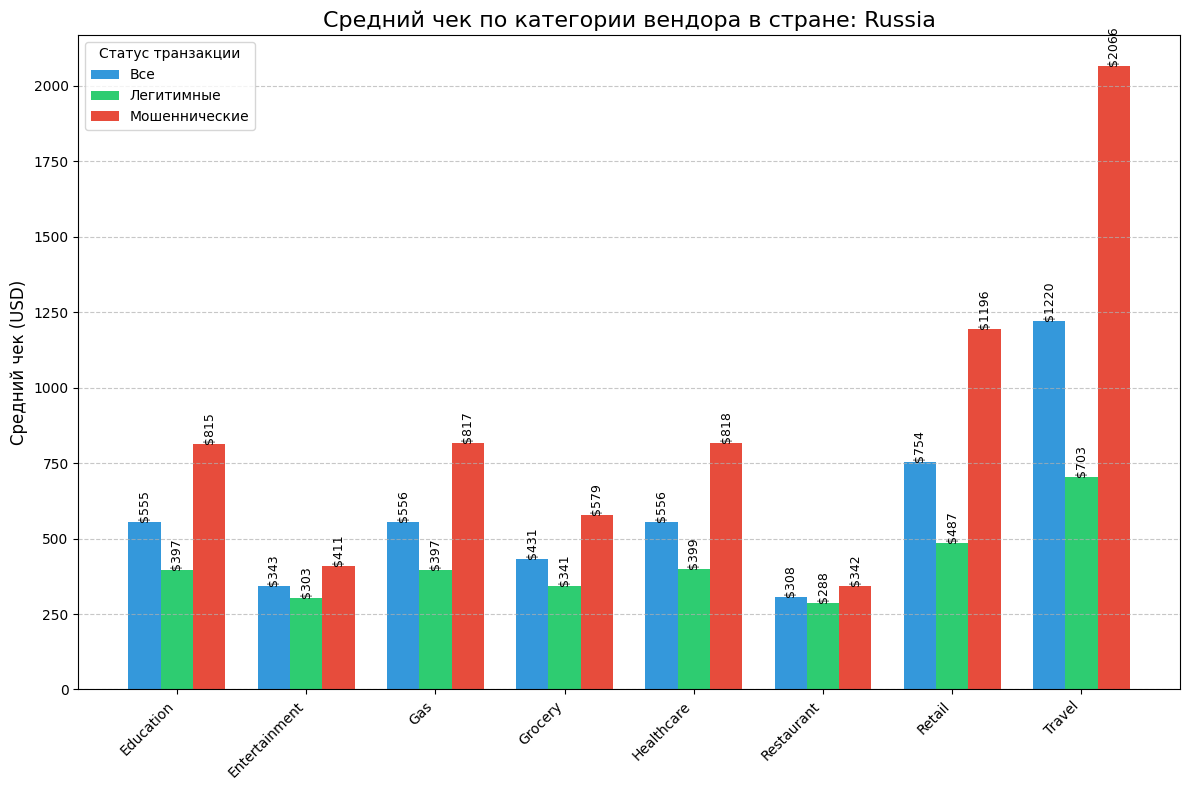

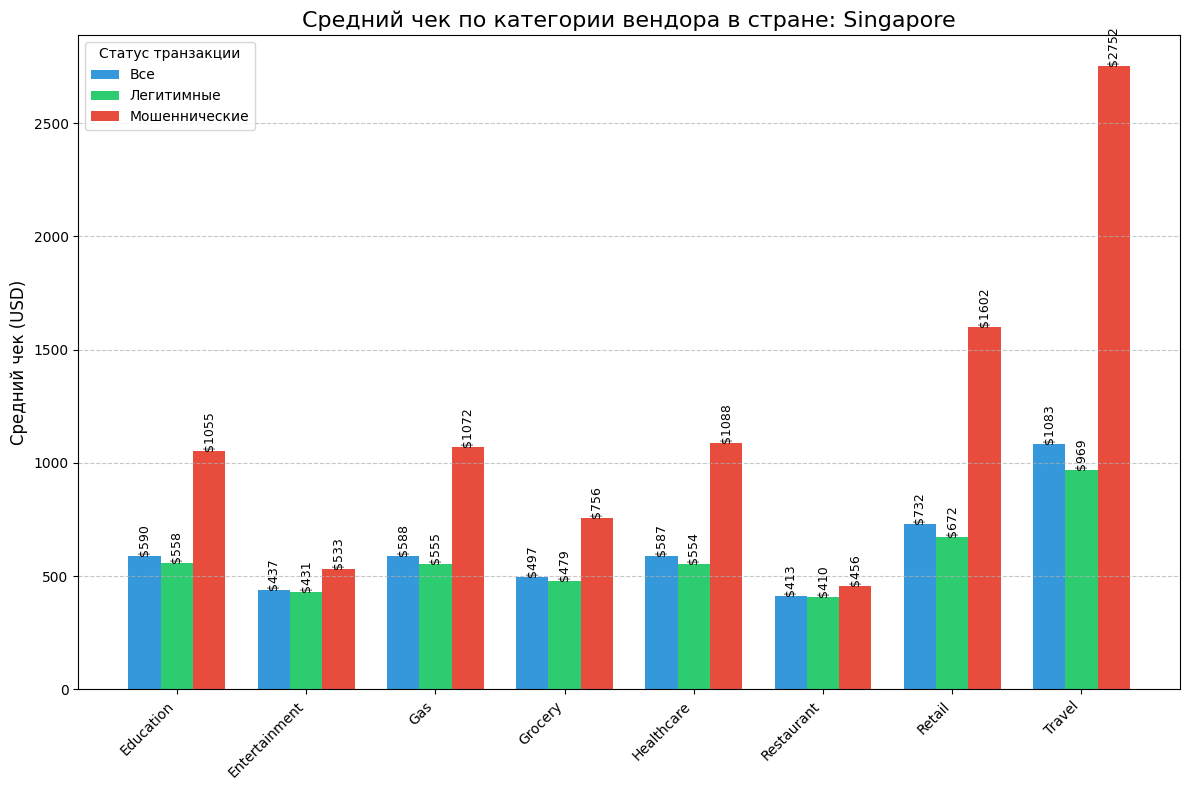

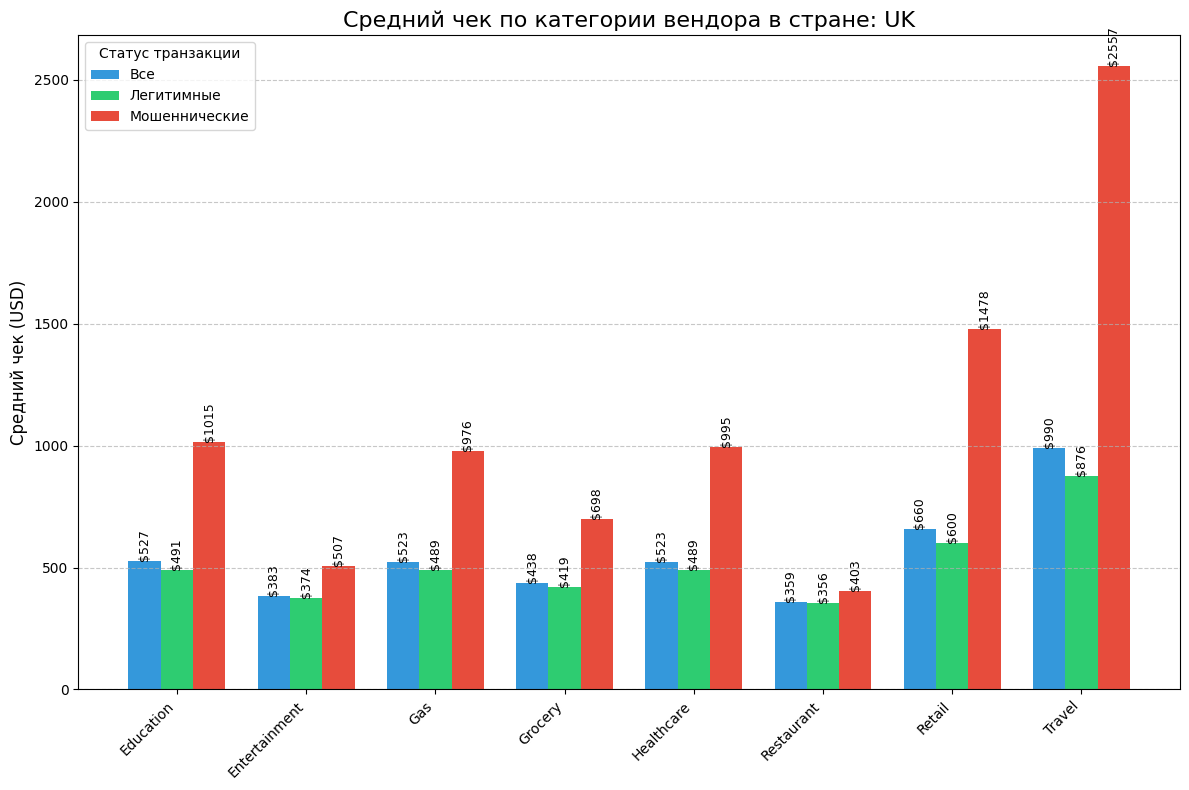

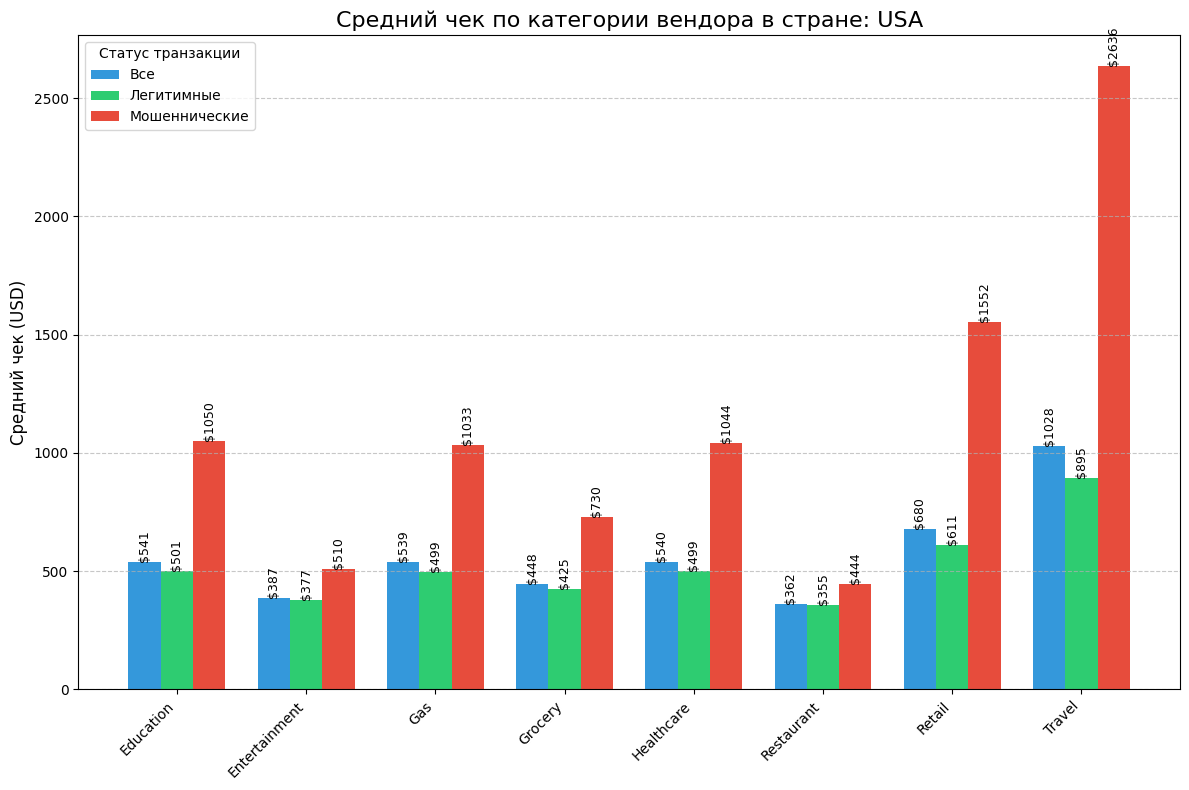

In [13]:
available_countries = list(plot_data_long['country'].unique())
for index in range(len(available_countries)):
    if index < len(available_countries) and len(available_countries) > 0:
        plot_country_data(available_countries[index], plot_data_long)

# Анализ по типам вендоров

In [14]:
avg_amount_by_status = transactions_df.groupby(['city', 'vendor_type', 'is_fraud'])['amount_usd'].mean().unstack(level='is_fraud').reset_index()
avg_amount_by_status.columns = ['city', 'vendor_type', 'avg_amount_non_fraud', 'avg_amount_fraud']

avg_amount_total = (
    transactions_df
    .groupby(['city', 'vendor_type'])['amount_usd']
    .mean()
    .reset_index()
    .rename(columns={
        'amount_usd': 'avg_amount_total'
        })
)

average_amount_by_city = pd.merge(avg_amount_total,
                                  avg_amount_by_status,
                                  on=['city', 'vendor_type'],
                                  how='left')
average_amount_by_city.fillna(0, inplace=True)
average_amount_by_city = average_amount_by_city[average_amount_by_city['city'] != 'Unknown City']

average_amount_by_city

,city,vendor_type,avg_amount_total,avg_amount_non_fraud,avg_amount_fraud
0,Chicago,airlines,1317.675548,1125.833749,3502.540476
1,Chicago,booking,1678.950510,1414.398726,5127.832018
2,Chicago,casual,286.734503,294.240940,198.658970
3,Chicago,events,526.349787,501.722118,861.818581
4,Chicago,fast_food,264.450281,278.799809,72.309078
...,...,...,...,...,...
165,San Jose,physical,480.954869,453.888033,806.877681
166,San Jose,premium,550.622802,504.748251,1085.825906
167,San Jose,streaming,262.371258,276.035321,112.148383
168,San Jose,supplies,548.228961,503.075385,1041.155492


In [15]:
top_5_cities = (
    transactions_df[transactions_df['is_fraud']]['city']
    .value_counts()
    .drop(index=['Unknown City'])
    .head(5)
)
print("Топ-5 городов с наибольшим количеством мошеннических транзакций:")
print(top_5_cities)

Топ-5 городов с наибольшим количеством мошеннических транзакций:
city
Phoenix         3786
San Jose        3777
San Diego       3771
Los Angeles     3771
Philadelphia    3739
Name: count, dtype: int64


In [16]:
d = (
    transactions_df
    .groupby('city')['amount_usd']
    .mean()
    .drop(index=['Unknown City'])
    .reset_index()
    .rename(columns={'amount_usd': 'avg_amount_usd'})
    .sort_values('avg_amount_usd', ascending=False)
    .reset_index(drop=True)
    .head(1)
    .to_dict()
)
city_with_highest_avg, value_avg_for_city_with_highest_avg = d['city'][0], d['avg_amount_usd'][0]
print(city_with_highest_avg, value_avg_for_city_with_highest_avg)

New York 568.8724674229495


In [17]:
d = (
    transactions_df[transactions_df['vendor_type'] == 'fast_food']
    .groupby('city')['amount_usd']
    .mean()
    .drop(index=['Unknown City'])
    .reset_index()
    .rename(columns={'amount_usd': 'avg_amount_usd'})
    .sort_values('avg_amount_usd', ascending=False)
    .reset_index(drop=True)
    .head(1)
    .to_dict()
)
transactions_df.drop(columns=['vendor_type'], inplace=True)
city_with_highest_avg_fast_food, value_avg_for_city_with_highest_avg_fast_food = d['city'][0], d['avg_amount_usd'][0]
print(city_with_highest_avg_fast_food, value_avg_for_city_with_highest_avg_fast_food)

Chicago 264.4502809265648


In [18]:
pivot_for_sorting = average_amount_by_city.pivot(index='city',
                                                 columns='vendor_type',
                                                 values='avg_amount_total')
pivot_for_sorting

vendor_type,airlines,booking,casual,events,fast_food,gaming,hotels,local,major,medical,online,pharmacy,physical,premium,streaming,supplies,transport
city,,,,,,,,,,,,,,,,,
Chicago,1317.675548,1678.950510,286.734503,526.349787,264.450281,370.117536,857.764087,535.985233,534.735948,543.060059,614.291869,534.887465,477.165347,544.691933,260.143542,531.904052,292.615148
Dallas,1272.828442,1663.316643,303.481211,521.544728,248.685716,346.435438,816.541136,540.936285,552.064987,544.571482,615.816227,540.585663,475.948741,536.983611,261.161606,539.284495,300.678255
Houston,1300.893018,1747.883172,288.104161,525.623140,246.913137,358.753173,807.175032,531.657675,524.737592,542.408354,606.018544,529.850493,477.799588,535.942079,274.208719,542.324398,298.896728
Los Angeles,1302.891792,1642.809176,288.702222,539.509707,255.950324,348.591135,831.491215,536.099500,544.032137,544.275405,609.576018,527.849545,484.903660,544.250922,266.861916,549.467802,302.663113
New York,1302.491330,1677.308392,302.215679,544.928691,263.296441,353.173050,828.749446,536.978442,547.216491,537.788918,611.984991,546.965444,479.084894,530.374913,280.729616,540.211464,302.169267
Philadelphia,1309.964872,1645.614965,280.910165,534.070775,243.440463,367.272865,828.243681,529.364872,532.548839,547.595618,617.949382,542.712254,479.452108,538.277367,263.735829,543.263608,292.801432
Phoenix,1365.381016,1648.189112,279.423587,549.484653,242.334715,358.999019,841.392051,549.969679,540.358310,527.870672,611.509469,548.437045,473.175461,554.307388,253.560397,543.951186,299.660714
San Antonio,1353.528374,1692.932200,294.276274,536.207228,258.169691,355.859116,839.072715,535.104490,533.881046,545.437956,626.241663,544.496817,475.112937,540.820611,263.892126,537.563540,299.351488
San Diego,1312.713822,1659.788529,286.830693,547.310957,254.343884,349.248075,850.685686,541.628222,553.915279,545.994024,614.214533,534.542701,475.000909,549.403523,273.564594,552.688940,282.206690


In [19]:
def plot_city_data(city_name, data):
    """
    Строит график среднего чека по типам вендоров для одного города.

    Args:
        city_name (str): Название города, для которого строится график.
        data (pd.DataFrame): DataFrame в "длинном" формате (plot_data_long).
    """
    city_data = data[data['city'] == city_name].copy()

    if city_data.empty:
        print(f"Город '{city_name}' не найден в данных.")
        return

    fig, ax = plt.subplots(figsize=(12, 8))

    vendor_types = city_data['vendor_type'].unique()
    n_vendors = len(vendor_types)
    statuses = ['Все', 'Легитимные', 'Мошеннические']
    colors = {'Все': '#3498db', 'Легитимные': '#2ecc71', 'Мошеннические': '#e74c3c'}
    bar_width = 0.25
    x_positions = np.arange(n_vendors)

    for k, status in enumerate(statuses):
        offset = (k - 1) * bar_width
        values = []
        for vendor in vendor_types:
            value_row = city_data[(city_data['vendor_type'] == vendor) & (city_data['status'] == status)]
            values.append(value_row['avg_amount'].iloc[0] if not value_row.empty else 0)

        bars = ax.bar(x_positions + offset, values, bar_width, label=status, color=colors[status])
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'${height:.0f}',
                        ha='center', va='bottom', fontsize=9, rotation=90)

    ax.set_title(f'Средний чек по типам вендоров в городе: {city_name}', fontsize=16)
    ax.set_ylabel('Средний чек (USD)', fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(vendor_types, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(bottom=0)
    ax.legend(title='Статус транзакции')

    plt.tight_layout()
    plt.show()


plot_data_long = pd.melt(average_amount_by_city,
                         id_vars=['city', 'vendor_type'],
                         value_vars=['avg_amount_total',
                                     'avg_amount_fraud',
                                     'avg_amount_non_fraud'],
                         var_name='status',
                         value_name='avg_amount')
plot_data_long['status'] = plot_data_long['status'].map({'avg_amount_total': 'Все',
                                                         'avg_amount_fraud': 'Мошеннические',
                                                         'avg_amount_non_fraud': 'Легитимные'})
plot_data_long

,city,vendor_type,status,avg_amount
0,Chicago,airlines,Все,1317.675548
1,Chicago,booking,Все,1678.950510
2,Chicago,casual,Все,286.734503
3,Chicago,events,Все,526.349787
4,Chicago,fast_food,Все,264.450281
...,...,...,...,...
505,San Jose,physical,Легитимные,453.888033
506,San Jose,premium,Легитимные,504.748251
507,San Jose,streaming,Легитимные,276.035321
508,San Jose,supplies,Легитимные,503.075385


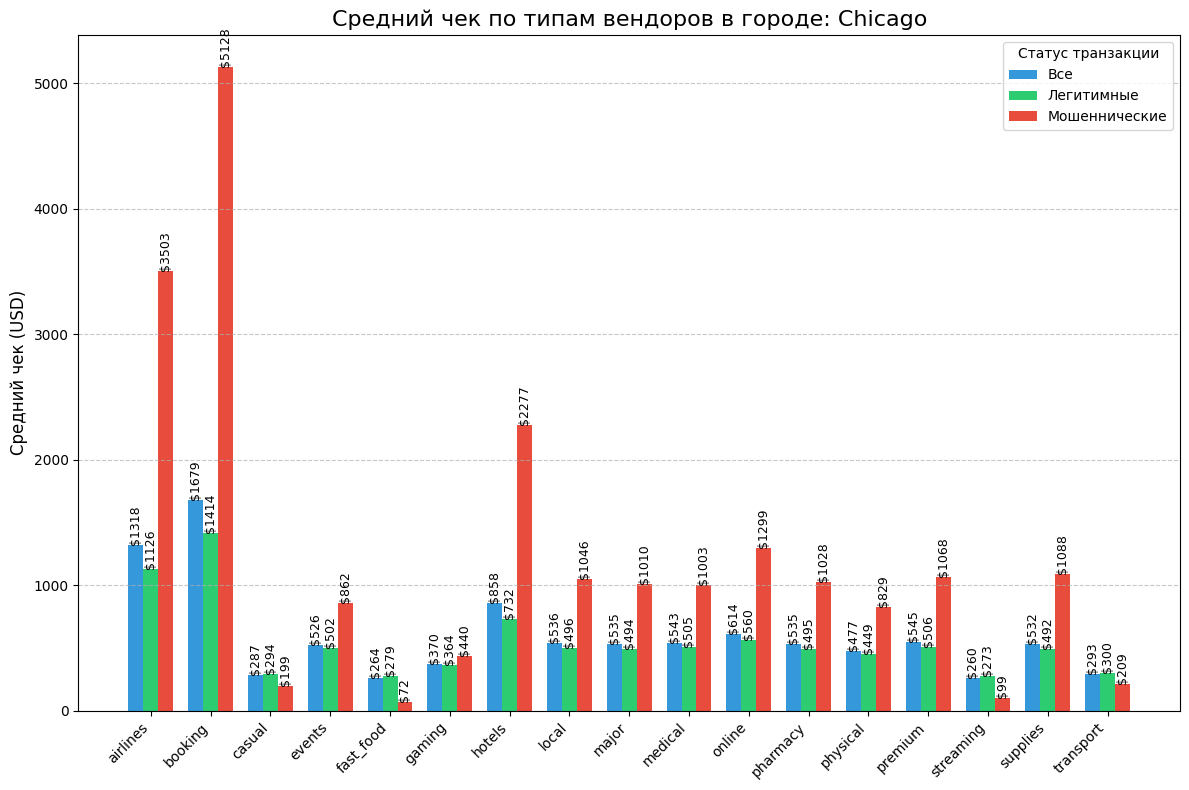

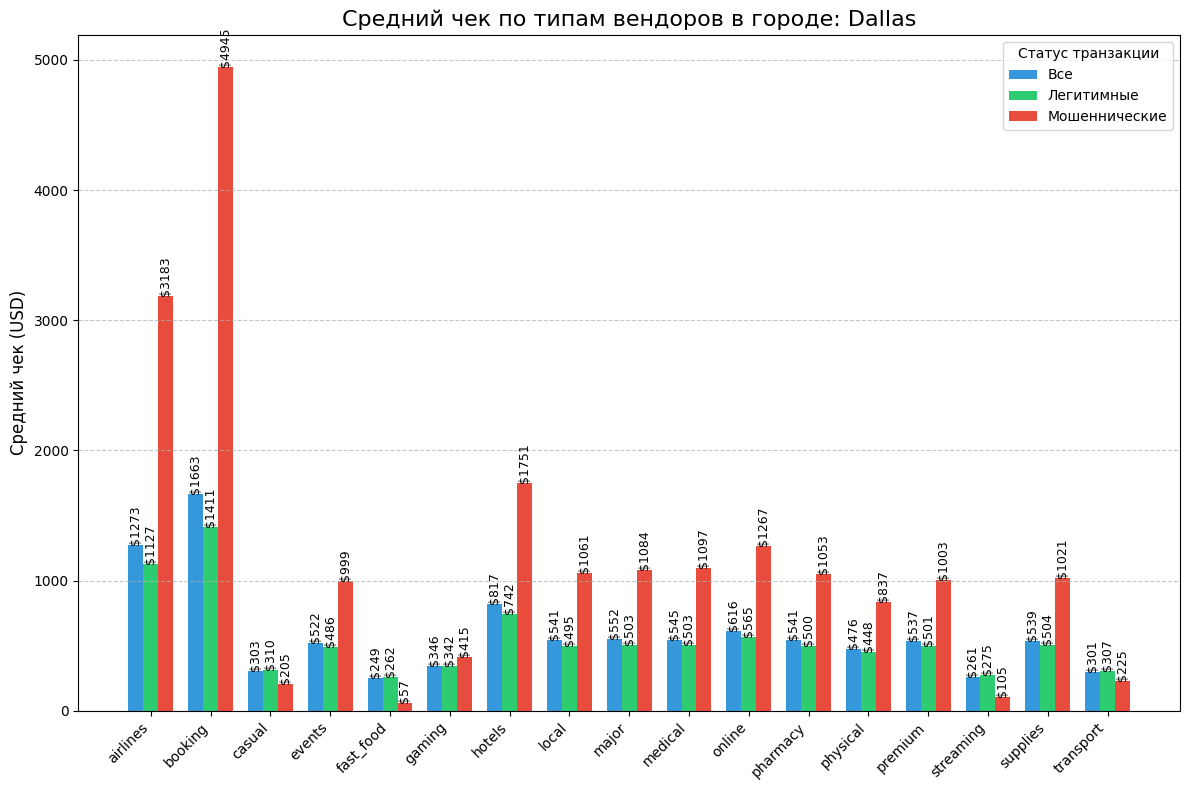

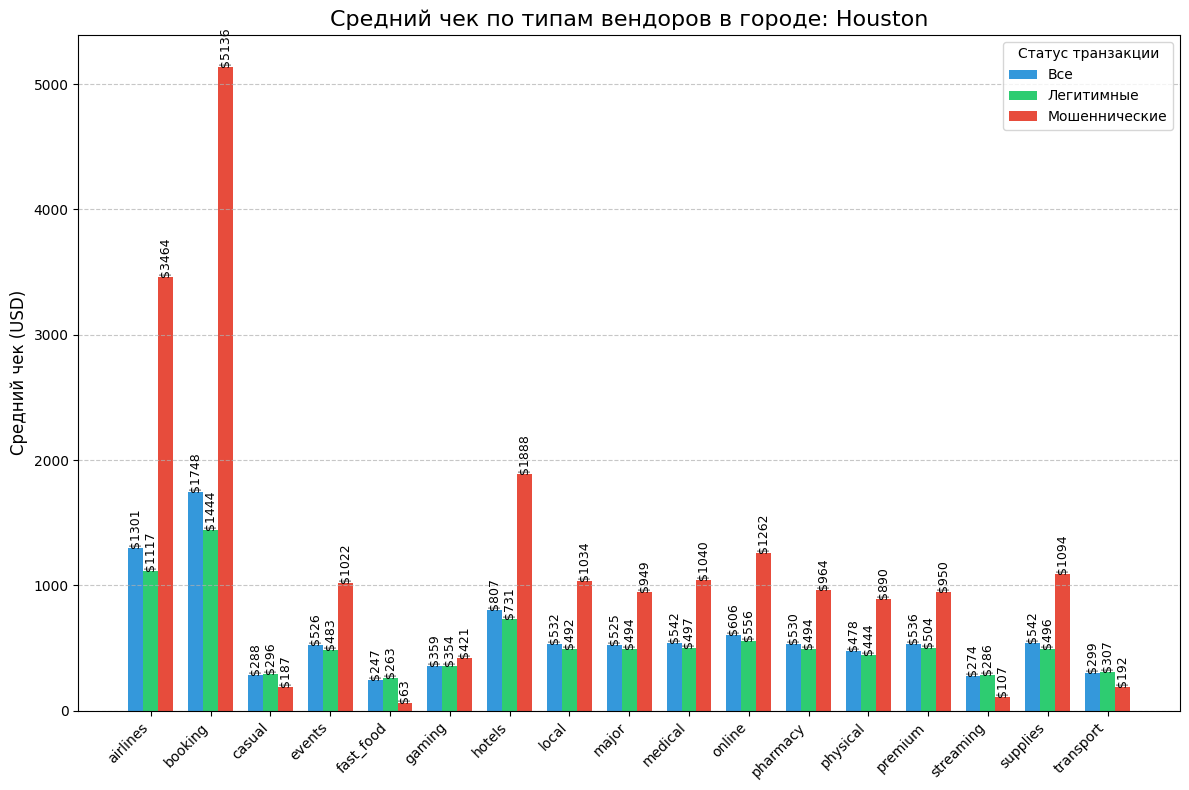

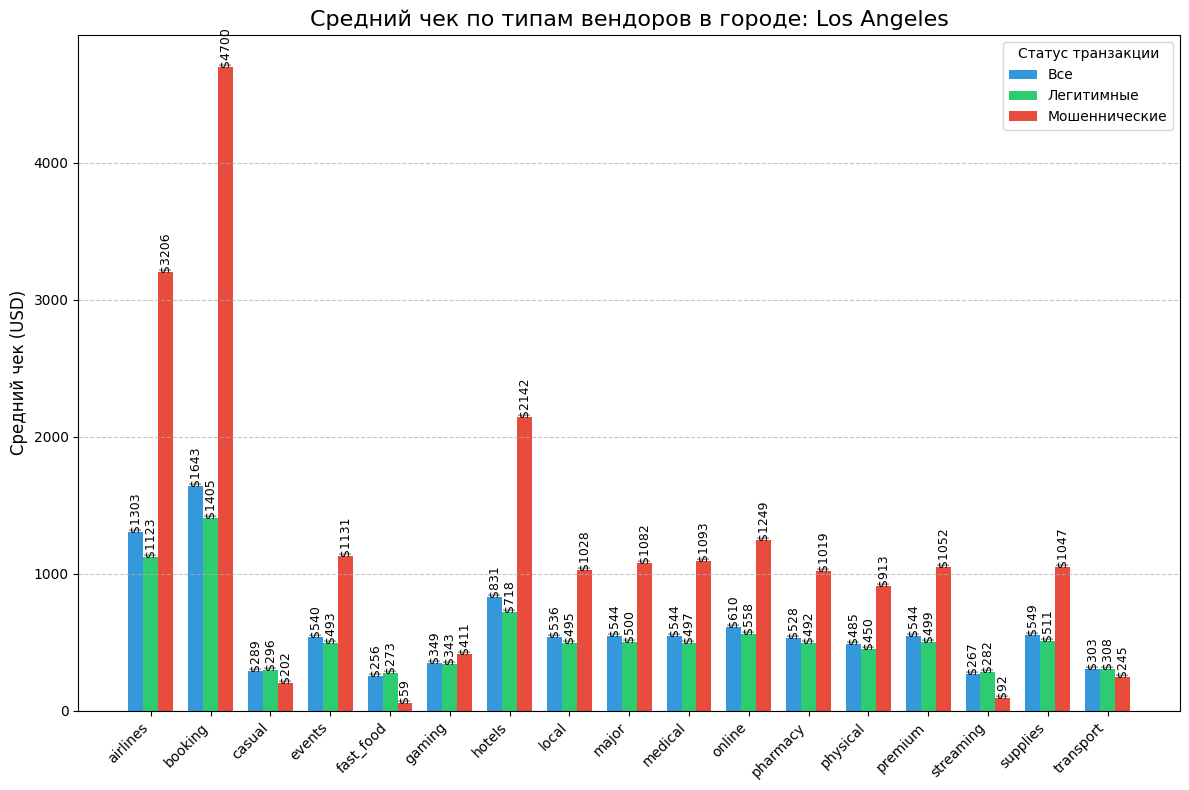

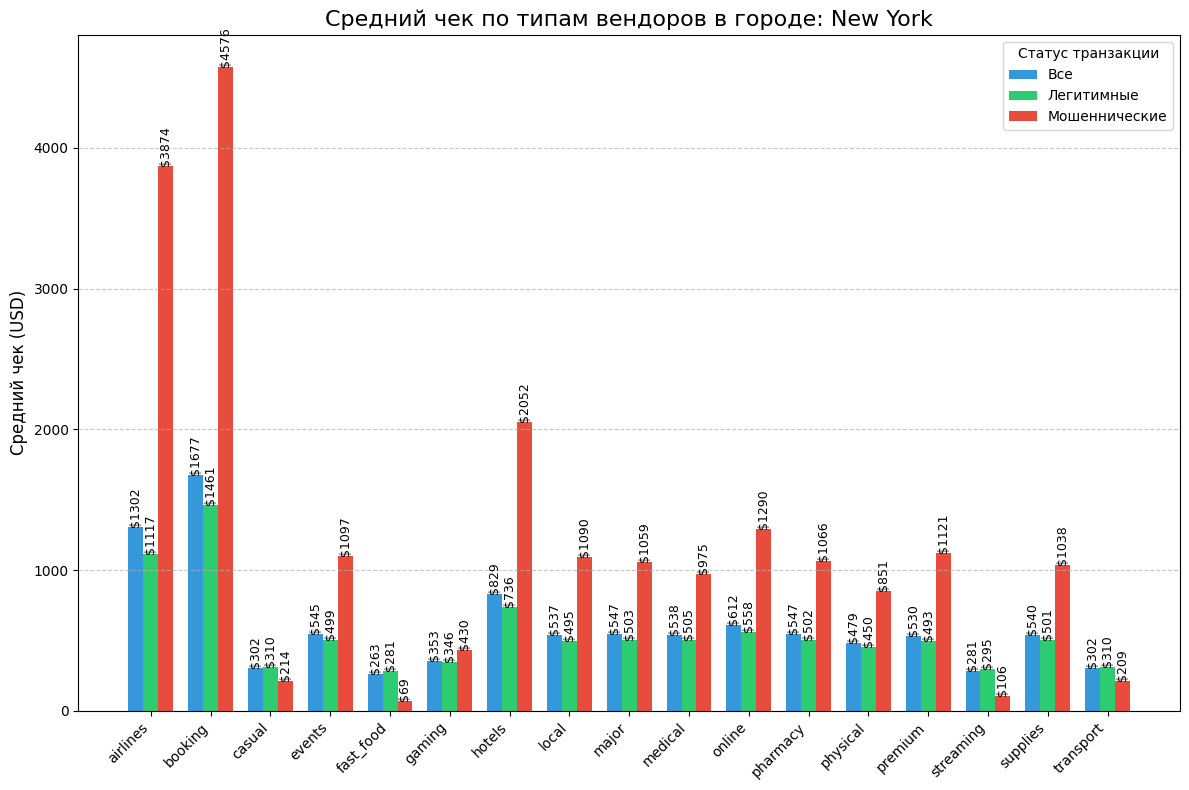

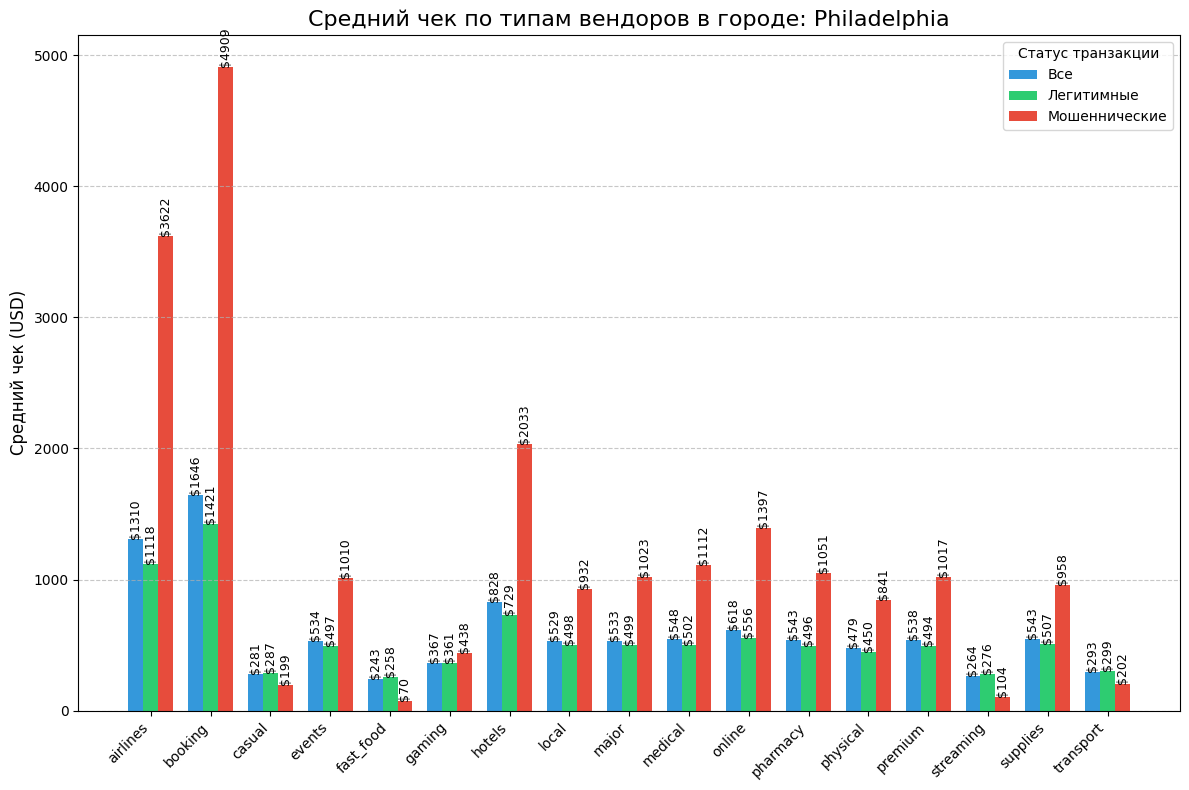

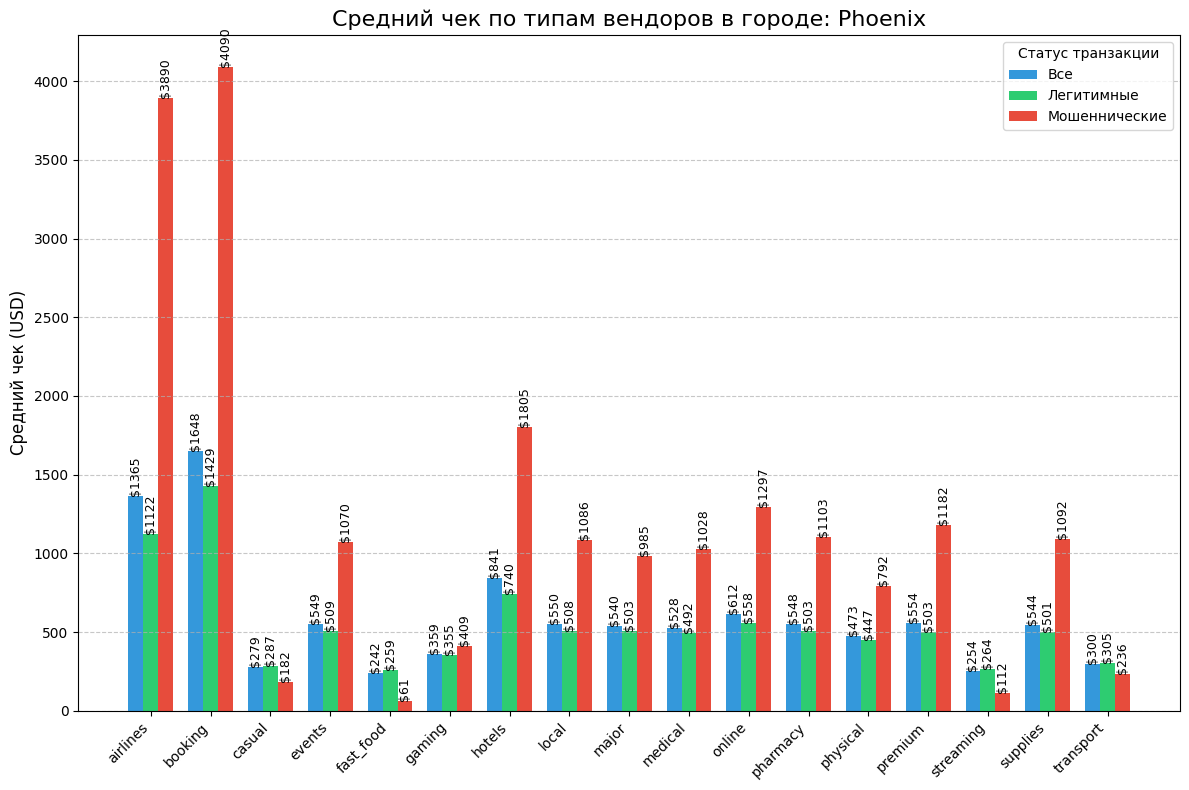

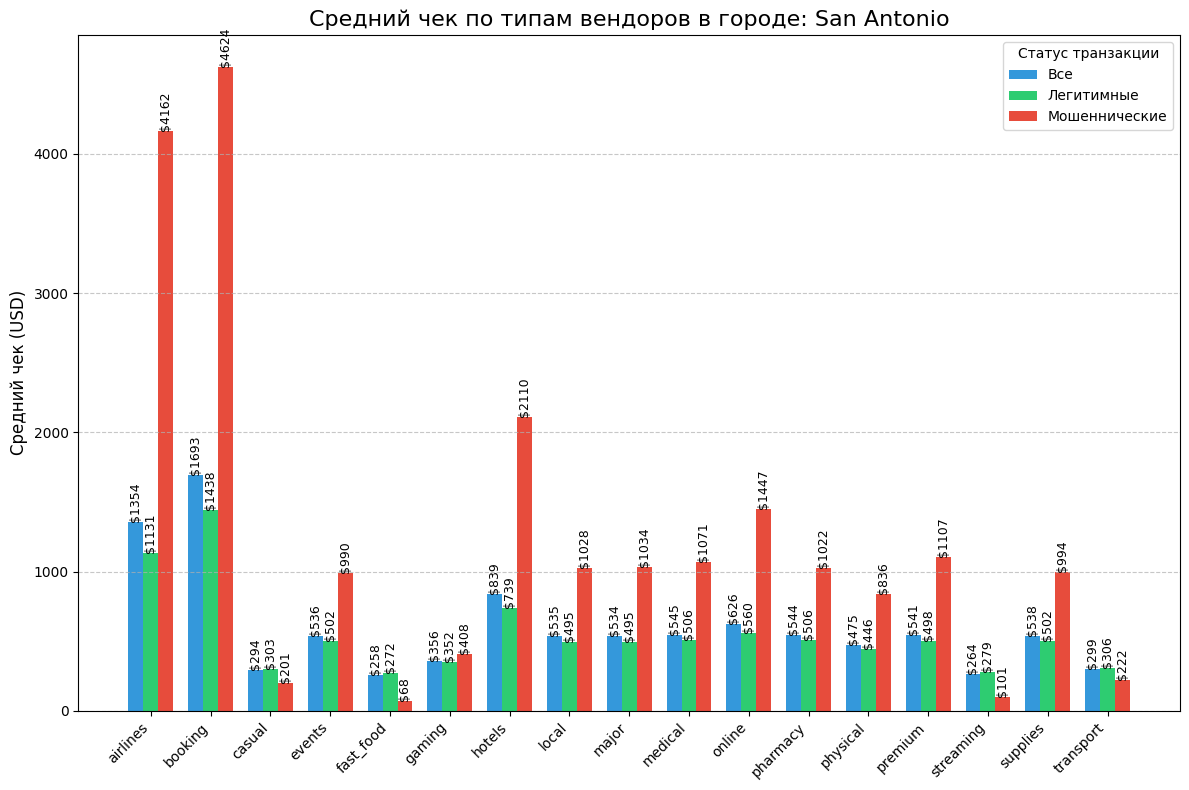

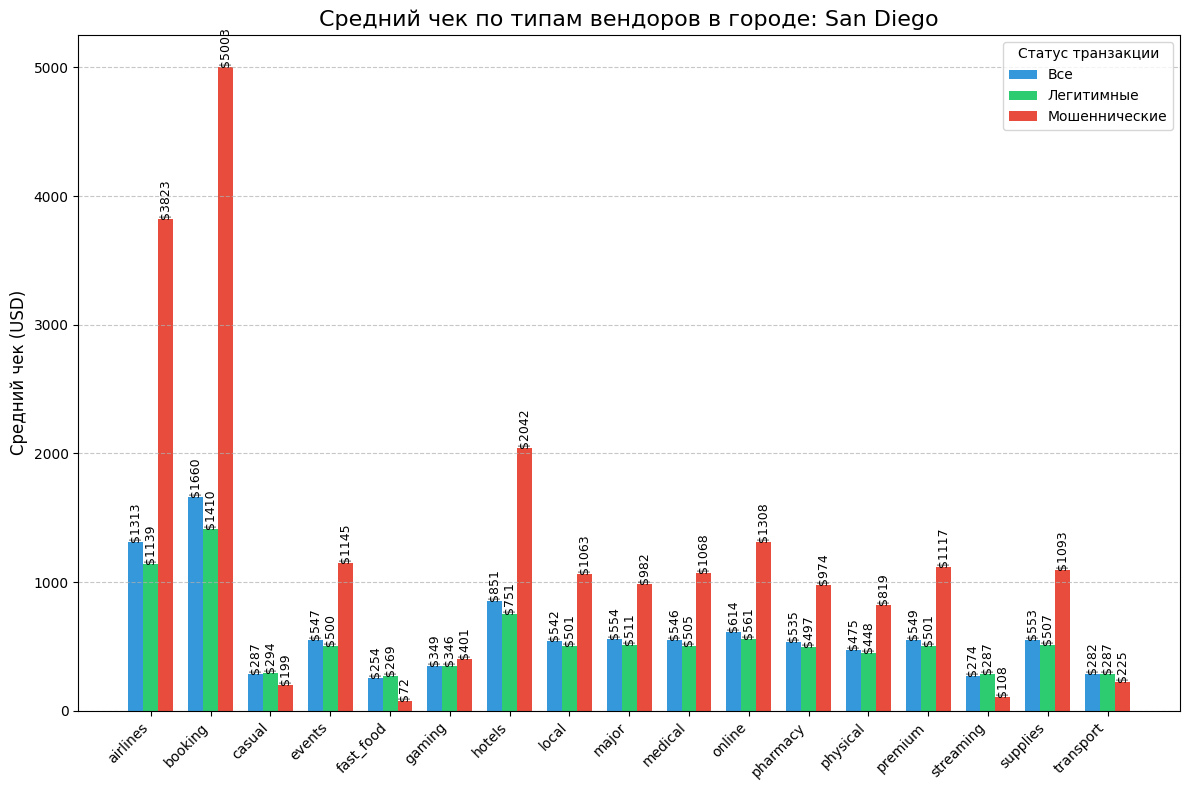

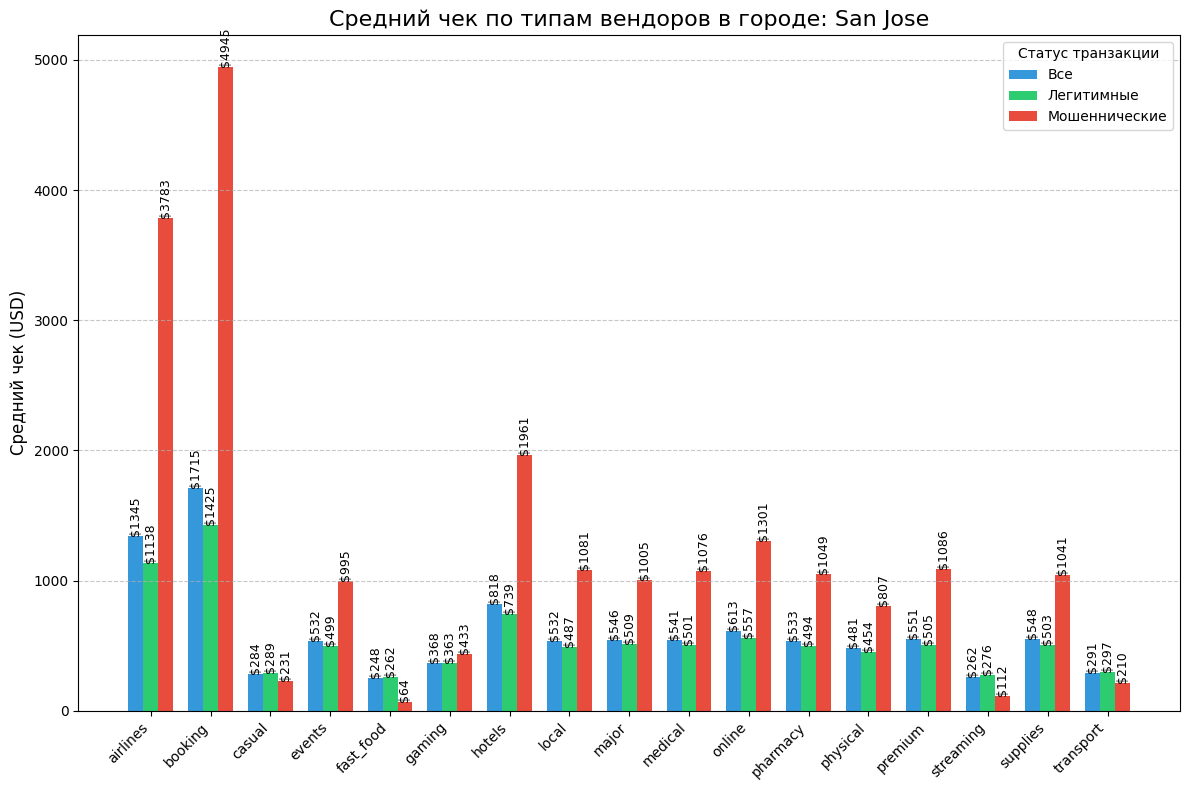

In [20]:
available_cities = list(plot_data_long['city'].unique())
for index in range(len(available_cities)):
    if index < len(available_cities) and len(available_cities) > 0:
        plot_city_data(available_cities[index], plot_data_long)

# Клиенты, которые демонстрируют потенциально опасное поведение

In [21]:
median_merchants_per_customer = (
    transactions_df.groupby('customer_id')['unique_merchants_last_hour']
    .median()
)
quantile_95_threshold = median_merchants_per_customer.quantile(0.95)
risky_customers = (
    median_merchants_per_customer
     [median_merchants_per_customer > quantile_95_threshold]
    )
risky_customers_count = risky_customers.count()
risky_customers_id = list(risky_customers.index)
risky_transactions_df = (
    transactions_df[transactions_df['customer_id'].isin(risky_customers_id)]
    .copy()
)
risky_transactions_df

,transaction_id,customer_id,vendor_category,timestamp,vendor,country,city,is_high_risk_vendor,is_fraud,unique_merchants_last_hour,date,amount_usd
12,TX_e9daa8b9,CUST_82514,Restaurant,2024-09-30 00:00:10.429065,Nobu,Germany,Unknown City,False,False,84,2024-09-30,298.049068
24,TX_5595b6f4,CUST_79361,Grocery,2024-09-30 00:00:21.797955,Walmart Grocery,Japan,Unknown City,False,False,71,2024-09-30,331.707203
28,TX_44db74bc,CUST_97591,Retail,2024-09-30 00:00:27.348964,Etsy,Brazil,Unknown City,False,True,105,2024-09-30,4207.536014
30,TX_f654b5a8,CUST_81662,Retail,2024-09-30 00:00:28.758598,Costco,Japan,Unknown City,False,False,87,2024-09-30,341.454052
32,TX_e7fbaaed,CUST_34938,Restaurant,2024-09-30 00:00:29.372674,Taco Bell,Germany,Unknown City,False,True,105,2024-09-30,56.443189
...,...,...,...,...,...,...,...,...,...,...,...,...
7483706,TX_a2d5656c,CUST_27724,Education,2024-10-30 23:59:40.571669,Chegg,Nigeria,Unknown City,False,False,1,2024-10-30,66.401948
7483707,TX_21c376ec,CUST_76118,Restaurant,2024-10-30 23:59:40.913249,Olive Garden,Mexico,Unknown City,False,False,8,2024-10-30,894.369698
7483730,TX_c36c7f79,CUST_23783,Grocery,2024-10-30 23:59:50.369618,Aldi,Germany,Unknown City,False,False,1,2024-10-30,241.225893
7483735,TX_9ed0a8bb,CUST_26548,Healthcare,2024-10-30 23:59:52.669036,DuaneReade,Russia,Unknown City,False,True,1,2024-10-30,687.683017


# Анализ по времени

In [22]:
transactions_df['hour'] = transactions_df['timestamp'].dt.hour

transactions_df['day_of_week'] = transactions_df['timestamp'].dt.day_name()


days_order = ["Monday",
              "Tuesday",
              "Wednesday",
              "Thursday",
              "Friday",
              "Saturday",
              "Sunday"]
transactions_df['day_of_week'] = pd.Categorical(transactions_df['day_of_week'],
                                                categories=days_order,
                                                ordered=True)


print("Данные обогащены признаками 'hour' и 'day_of_week'.")
transactions_df[['timestamp', 'hour', 'day_of_week', 'is_fraud']].head()

Данные обогащены признаками 'hour' и 'day_of_week'.


,timestamp,hour,day_of_week,is_fraud
0,2024-09-30 00:00:01.034820,0,Monday,False
1,2024-09-30 00:00:01.764464,0,Monday,True
2,2024-09-30 00:00:02.273762,0,Monday,False
3,2024-09-30 00:00:02.297466,0,Monday,False
4,2024-09-30 00:00:02.544063,0,Monday,True


## Общее распределение транзакций по часам

In [23]:
avg_transactions_by_hour_df = (
    transactions_df
    .groupby('hour')
    .agg(
        {
            'transaction_id': 'count',
        }
    )
    .apply(lambda x: len(transactions_df) / x)
    .rename(columns={
        'transaction_id': 'avg_transactions_by_hour'
    })
)
avg_transactions_by_hour_df

,avg_transactions_by_hour
hour,
0,48.047079
1,26.714756
2,26.682753
3,26.724773
4,26.588522
5,35.888366
6,38.012775
7,24.848477
8,18.464208


In [24]:
avg_transactions_by_hour = avg_transactions_by_hour_df['avg_transactions_by_hour'].mean()
avg_transactions_by_hour

np.float64(25.645247241391957)

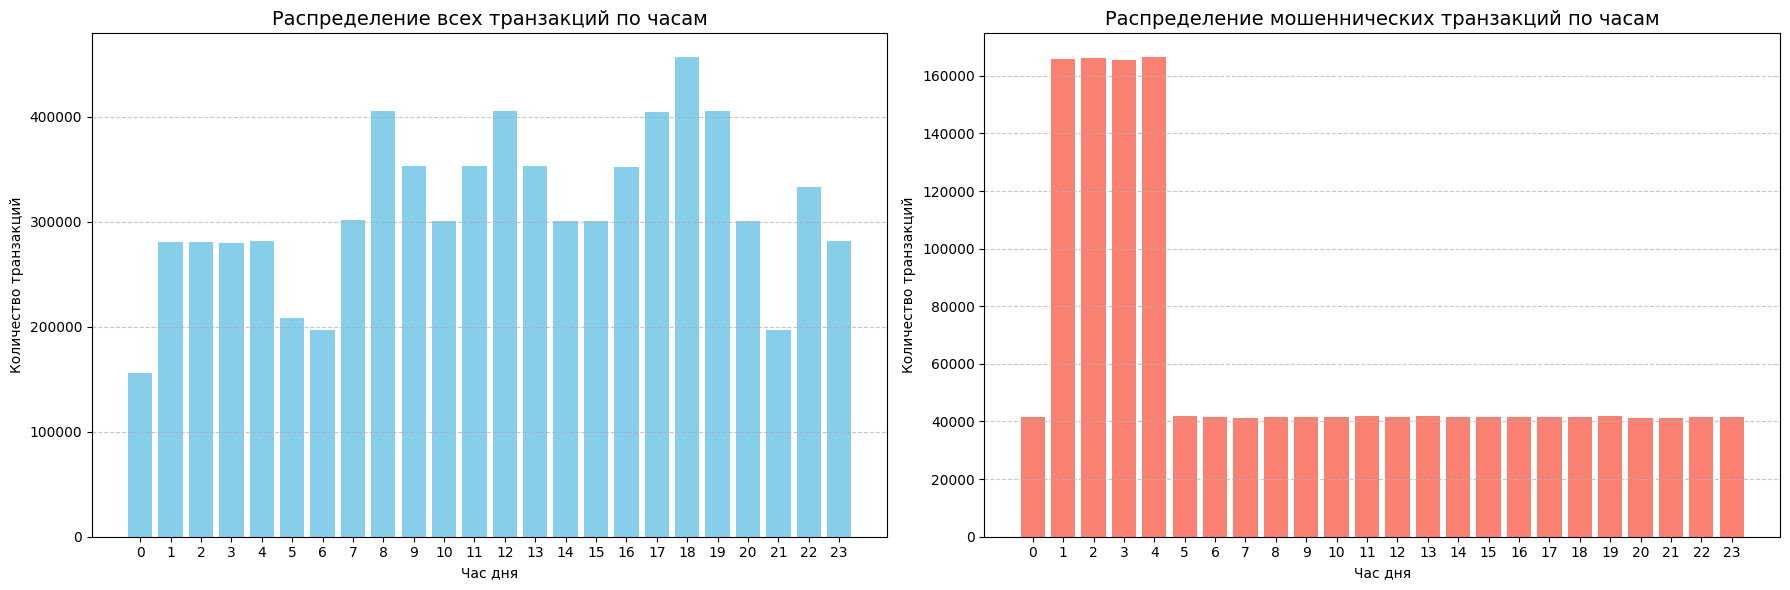

In [25]:
all_trans_by_hour = transactions_df['hour'].value_counts().sort_index()
fraud_trans_by_hour = (
    transactions_df[transactions_df['is_fraud']]['hour']
    .value_counts()
    .sort_index()
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(all_trans_by_hour.index, all_trans_by_hour.values, color='skyblue')
axes[0].set_title('Распределение всех транзакций по часам', fontsize=14)
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Количество транзакций')
axes[0].set_xticks(range(24))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(fraud_trans_by_hour.index, fraud_trans_by_hour.values, color='salmon')
axes[1].set_title('Распределение мошеннических транзакций по часам', fontsize=14)
axes[1].set_xlabel('Час дня')
axes[1].set_ylabel('Количество транзакций')
axes[1].set_xticks(range(24))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Уровень мошенничества по часам (Fraud Rate)

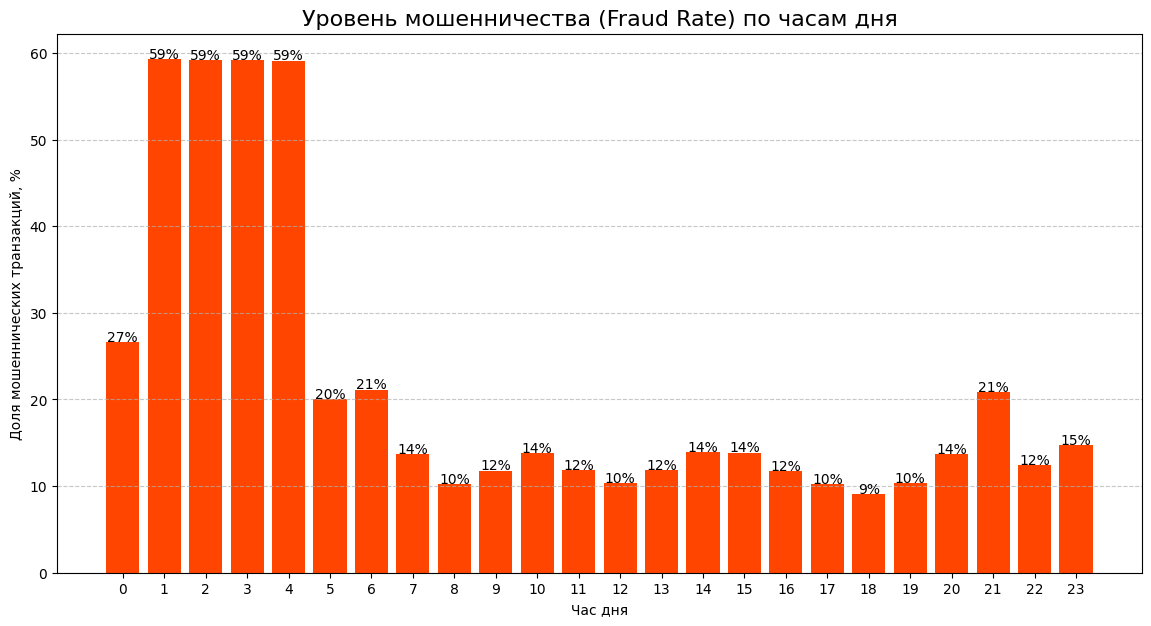

In [26]:
hourly_stats = transactions_df.groupby('hour').agg(
    total_transactions=('is_fraud', 'count'),
    fraud_transactions=('is_fraud', 'sum')
)

hourly_stats['fraud_rate'] = (hourly_stats['fraud_transactions'] / hourly_stats['total_transactions']) * 100

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(hourly_stats.index, hourly_stats['fraud_rate'], color='orangered')
ax.set_title('Уровень мошенничества (Fraud Rate) по часам дня', fontsize=16)
ax.set_xlabel('Час дня')
ax.set_ylabel('Доля мошеннических транзакций, %')
ax.set_xticks(range(24))
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, rate in enumerate(hourly_stats['fraud_rate']):
    ax.text(i, rate + 0.1, f'{round(rate)}%', ha='center')

plt.show()

## Тепловая карта активности (День недели vs. Час дня)

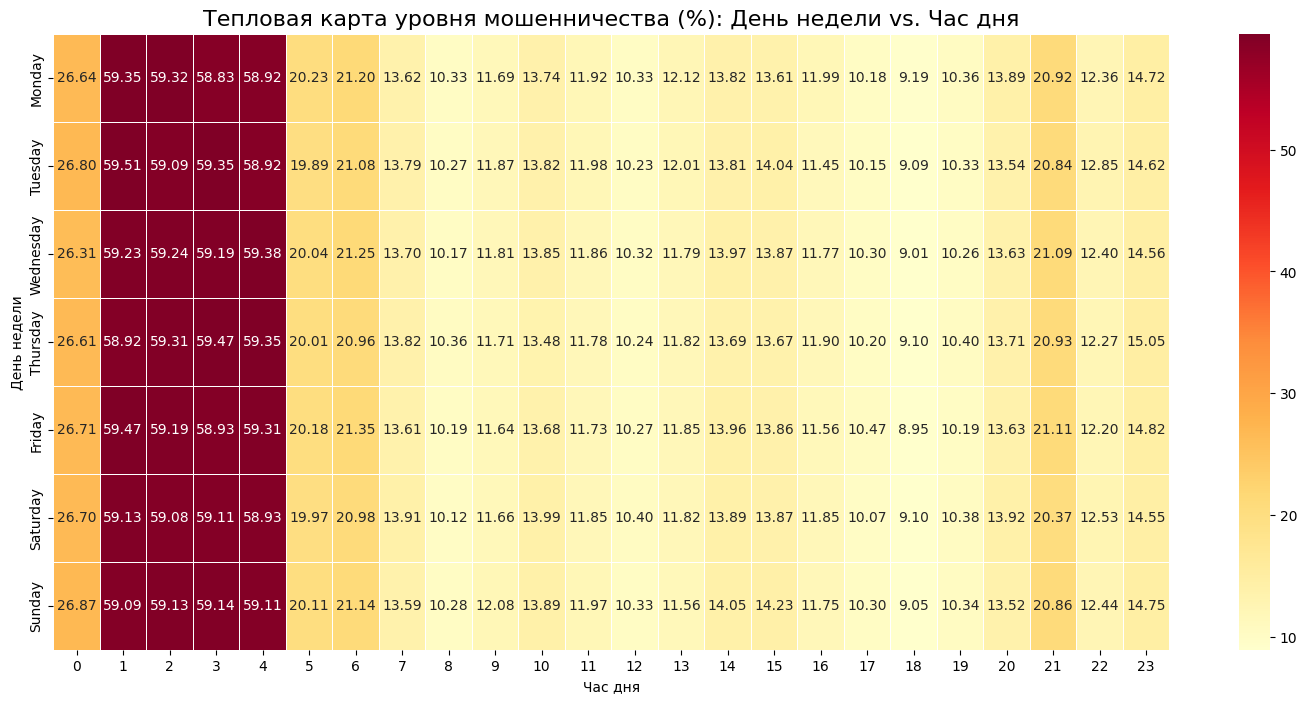

In [27]:
heatmap_data = transactions_df.groupby(['day_of_week', 'hour'], observed=True).agg(
    total_transactions=('is_fraud', 'count'),
    fraud_transactions=('is_fraud', 'sum')
).reset_index()

heatmap_data['fraud_rate'] = (heatmap_data['fraud_transactions'] / heatmap_data['total_transactions']) * 100

fraud_rate_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='fraud_rate')

plt.figure(figsize=(18, 8))
sns.heatmap(fraud_rate_pivot, cmap='YlOrRd', annot=True, fmt=".2f", linewidths=.5)
plt.title('Тепловая карта уровня мошенничества (%): День недели vs. Час дня', fontsize=16)
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.show()

# Результаты

In [28]:
non_fraud_df = transactions_df[~transactions_df['is_fraud']].copy()
fraud_df = transactions_df[transactions_df['is_fraud']].copy()

In [29]:
avg_usd_amount_non_fraud = non_fraud_df['amount_usd'].mean()
std_usd_amount_non_fraud = non_fraud_df['amount_usd'].std()
avg_usd_amount_fraud = fraud_df['amount_usd'].mean()
std_usd_amount_fraud = fraud_df['amount_usd'].std()
fraud_proportion = transactions_df['is_fraud'].mean()
fraud_high_risk_proportion = transactions_df[transactions_df['is_high_risk_vendor']]['is_fraud'].mean()

In [30]:
print("-" * 50)
print(f"Доля мошеннических транзакций: {round(fraud_proportion * 100, 2)}%")
print("-" * 50)
print(f"Топ-5 стран, где зафиксировано больше всего мошеннических транзакций: {', '.join(top_5_countries.index)}")
print("-" * 50)
print(f"Среднее количество транзакций на клиента в час: {avg_transactions_by_hour:.1f}")
print("-" * 50)
print(f"Доля мошенничества среди транзакций у продавцов с высоким риском: {round(fraud_high_risk_proportion * 100, 2)}%")
print("-" * 50)
print(f"Город с наибольшей средней суммой транзакции: {city_with_highest_avg}")
print(f"Средняя сумма: ${round(value_avg_for_city_with_highest_avg)}")
print("-" * 50)
print(f"Город в котором выше всего средний чек по операциям, связанным с fast_food: {city_with_highest_avg_fast_food}")
print(f"Средний чек: ${round(value_avg_for_city_with_highest_avg_fast_food)}")
print("-" * 50)
print(f"Средняя сумма немошеннической операции: ${round(avg_usd_amount_non_fraud)}")
print("-" * 50)
print(f"Среднеквадратичное отклонение среди всех немошеннических операций: ${round(std_usd_amount_non_fraud)}")
print("-" * 50)
print(f"Средняя сумма мошеннической операции: ${round(avg_usd_amount_fraud)}")
print("-" * 50)
print(f"Среднеквадратичное отклонение среди всех мошеннических операций: ${round(std_usd_amount_fraud)}")
print("-" * 50)
print(f"Количество клиентов, которые демонстрируют потенциально опасное поведение: {risky_customers_count}")
print("-" * 50)

--------------------------------------------------
Доля мошеннических транзакций: 19.97%
--------------------------------------------------
Топ-5 стран, где зафиксировано больше всего мошеннических транзакций: Russia, Mexico, Brazil, Nigeria, Australia
--------------------------------------------------
Среднее количество транзакций на клиента в час: 25.6
--------------------------------------------------
Доля мошенничества среди транзакций у продавцов с высоким риском: 20.0%
--------------------------------------------------
Город с наибольшей средней суммой транзакции: New York
Средняя сумма: $569
--------------------------------------------------
Город в котором выше всего средний чек по операциям, связанным с fast_food: Chicago
Средний чек: $264
--------------------------------------------------
Средняя сумма немошеннической операции: $460
--------------------------------------------------
Среднеквадратичное отклонение среди всех немошеннических операций: $417
----------------------

In [38]:
temp = (
    risky_transactions_df
     [(risky_transactions_df['country'] == 'Russia') &
      (risky_transactions_df['vendor_category'].isin(['Travel', 'Retail'])) &
      (risky_transactions_df['amount_usd'] > avg_usd_amount_fraud)]
    .copy()
    )
print(f"Анализ для {len(risky_customers_id)} клиентов, которые попали под подозрение.")
print("-" * 50)
temp

Анализ для 229 клиентов, которые попали под подозрение.
--------------------------------------------------


,transaction_id,customer_id,vendor_category,timestamp,vendor,country,city,is_high_risk_vendor,is_fraud,unique_merchants_last_hour,date,amount_usd,hour,day_of_week
768,TX_cb051dbe,CUST_41978,Travel,2024-09-30 00:08:41.636255,Expedia,Russia,Unknown City,True,True,97,2024-09-30,8850.135167,0,Monday
1499,TX_6a2ca531,CUST_97240,Travel,2024-09-30 00:17:34.672791,Booking.com,Russia,Unknown City,True,True,104,2024-09-30,11463.560944,0,Monday
2463,TX_51a1fb22,CUST_43114,Travel,2024-09-30 00:28:43.531570,Kayak,Russia,Unknown City,True,False,105,2024-09-30,996.337496,0,Monday
3244,TX_c4788c54,CUST_57816,Retail,2024-09-30 00:38:05.931991,Home Depot,Russia,Unknown City,False,True,105,2024-09-30,1531.693391,0,Monday
4145,TX_ed4b0c20,CUST_20782,Travel,2024-09-30 00:49:07.790794,Airbnb,Russia,Unknown City,True,True,93,2024-09-30,1582.759993,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475339,TX_e743a563,CUST_42473,Travel,2024-10-30 23:03:39.459147,Marriott,Russia,Unknown City,True,False,1,2024-10-30,1467.936748,23,Wednesday
7476908,TX_953166ed,CUST_84964,Retail,2024-10-30 23:13:38.370572,Newegg,Russia,Unknown City,False,False,1,2024-10-30,1150.692174,23,Wednesday
7477016,TX_cbf02ece,CUST_65575,Travel,2024-10-30 23:14:17.476317,Airbnb,Russia,Unknown City,True,False,7,2024-10-30,1054.020086,23,Wednesday
7480382,TX_5976340f,CUST_15783,Retail,2024-10-30 23:37:09.725309,Amazon,Russia,Unknown City,False,True,3,2024-10-30,3326.049900,23,Wednesday


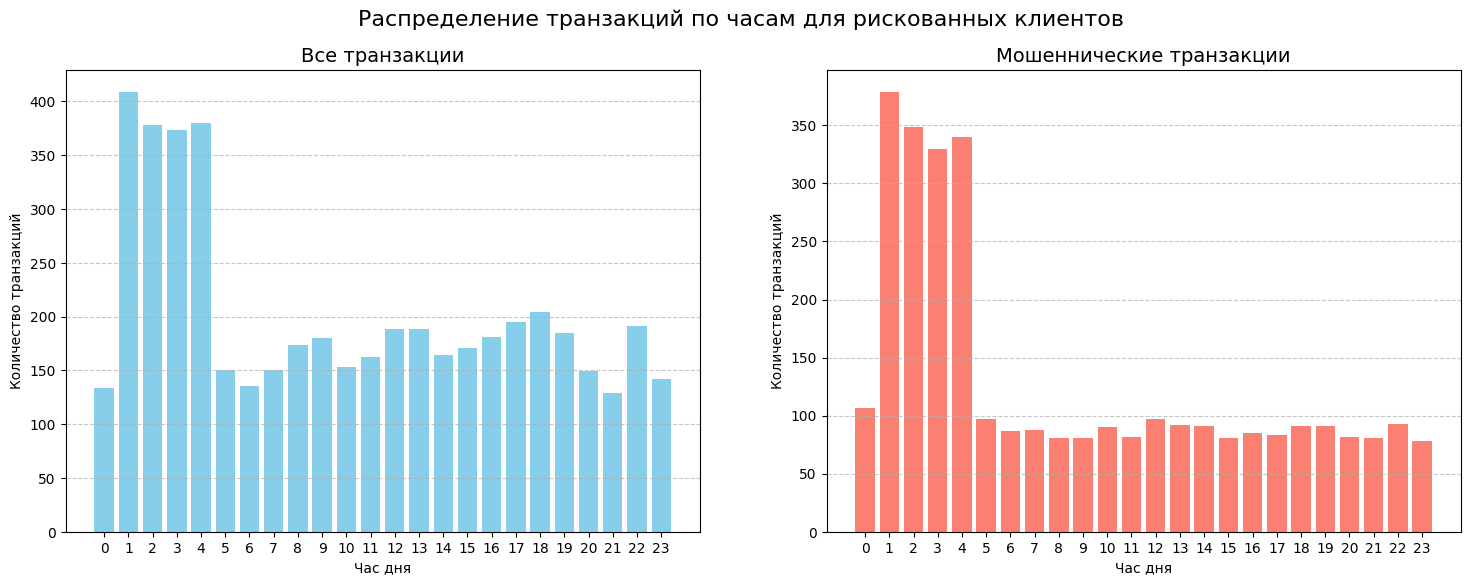

In [39]:
all_trans_by_hour_risky = temp['hour'].value_counts().sort_index()
fraud_trans_by_hour_risky = temp[temp['is_fraud']]['hour'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Распределение транзакций по часам для рискованных клиентов', fontsize=16)

axes[0].bar(all_trans_by_hour_risky.index, all_trans_by_hour_risky.values, color='skyblue')
axes[0].set_title('Все транзакции', fontsize=14)
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Количество транзакций')
axes[0].set_xticks(range(24))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(fraud_trans_by_hour_risky.index, fraud_trans_by_hour_risky.values, color='salmon')
axes[1].set_title('Мошеннические транзакции', fontsize=14)
axes[1].set_xlabel('Час дня')
axes[1].set_ylabel('Количество транзакций')
axes[1].set_xticks(range(24))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

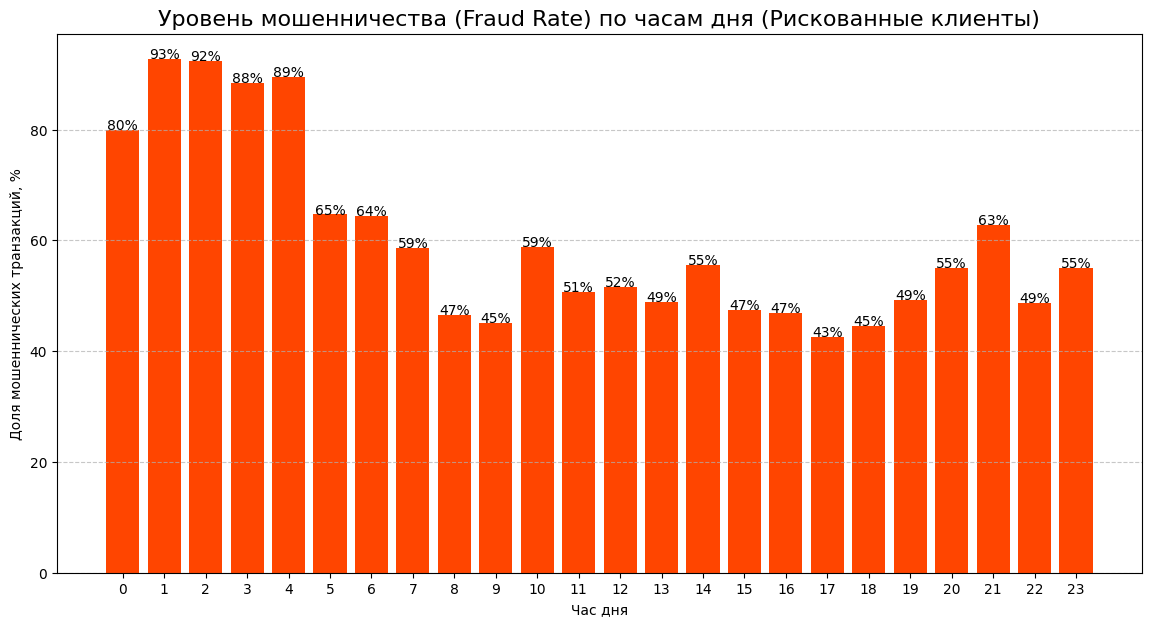

In [40]:
hourly_stats_risky = temp.groupby('hour').agg(
    total_transactions=('is_fraud', 'count'),
    fraud_transactions=('is_fraud', 'sum')
)
hourly_stats_risky['fraud_rate'] = (hourly_stats_risky['fraud_transactions'] / hourly_stats_risky['total_transactions']) * 100

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(hourly_stats_risky.index, hourly_stats_risky['fraud_rate'], color='orangered')
ax.set_title('Уровень мошенничества (Fraud Rate) по часам дня (Рискованные клиенты)', fontsize=16)
ax.set_xlabel('Час дня')
ax.set_ylabel('Доля мошеннических транзакций, %')
ax.set_xticks(range(24))
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in hourly_stats_risky.index:
    rate = hourly_stats_risky.loc[i, 'fraud_rate']
    ax.text(i, rate + 0.1, f'{round(rate)}%', ha='center')

Text(195.72222222222223, 0.5, 'День недели')

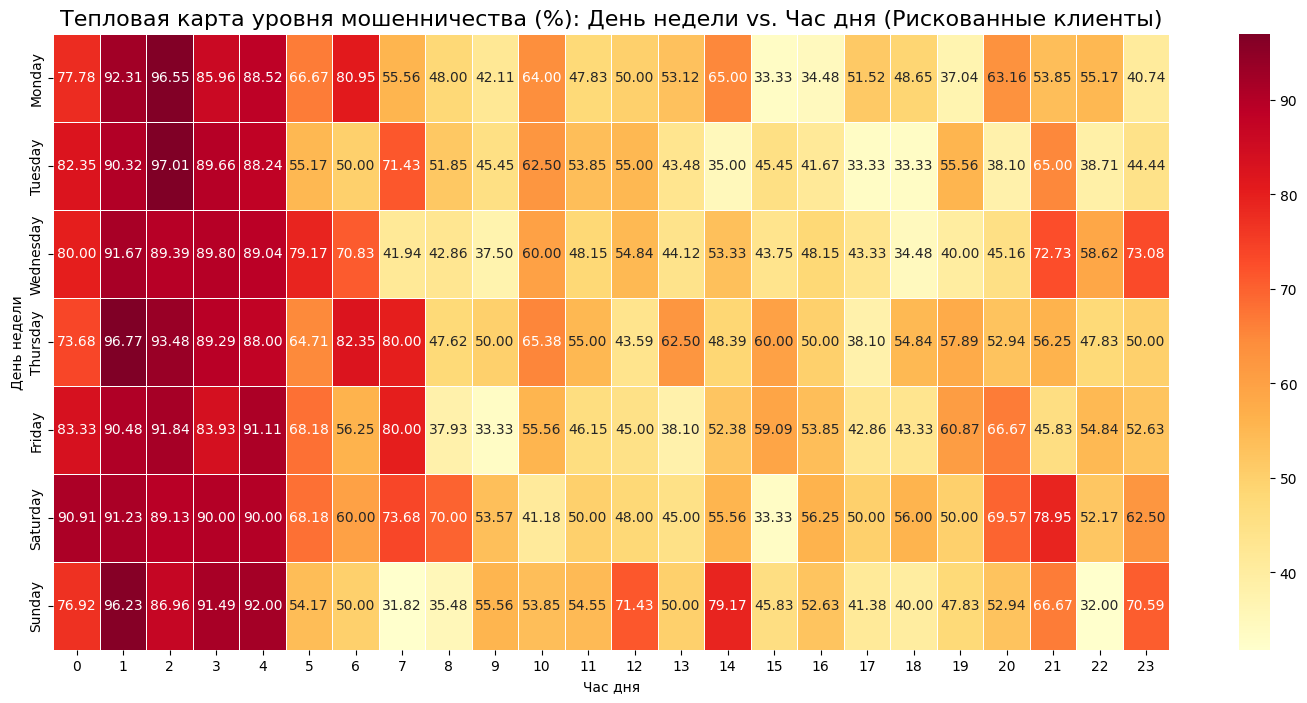

In [41]:
heatmap_data_risky = temp.groupby(['day_of_week', 'hour'], observed=True).agg(
    total_transactions=('is_fraud', 'count'),
    fraud_transactions=('is_fraud', 'sum')
).reset_index()
heatmap_data_risky['fraud_rate'] = (heatmap_data_risky['fraud_transactions'] / heatmap_data_risky['total_transactions']) * 100
fraud_rate_pivot_risky = heatmap_data_risky.pivot(index='day_of_week', columns='hour', values='fraud_rate')

plt.figure(figsize=(18, 8))
sns.heatmap(fraud_rate_pivot_risky, cmap='YlOrRd', annot=True, fmt=".2f", linewidths=.5)
plt.title('Тепловая карта уровня мошенничества (%): День недели vs. Час дня (Рискованные клиенты)', fontsize=16)
plt.xlabel('Час дня')
plt.ylabel('День недели')